## Player Position Prediction + EDA

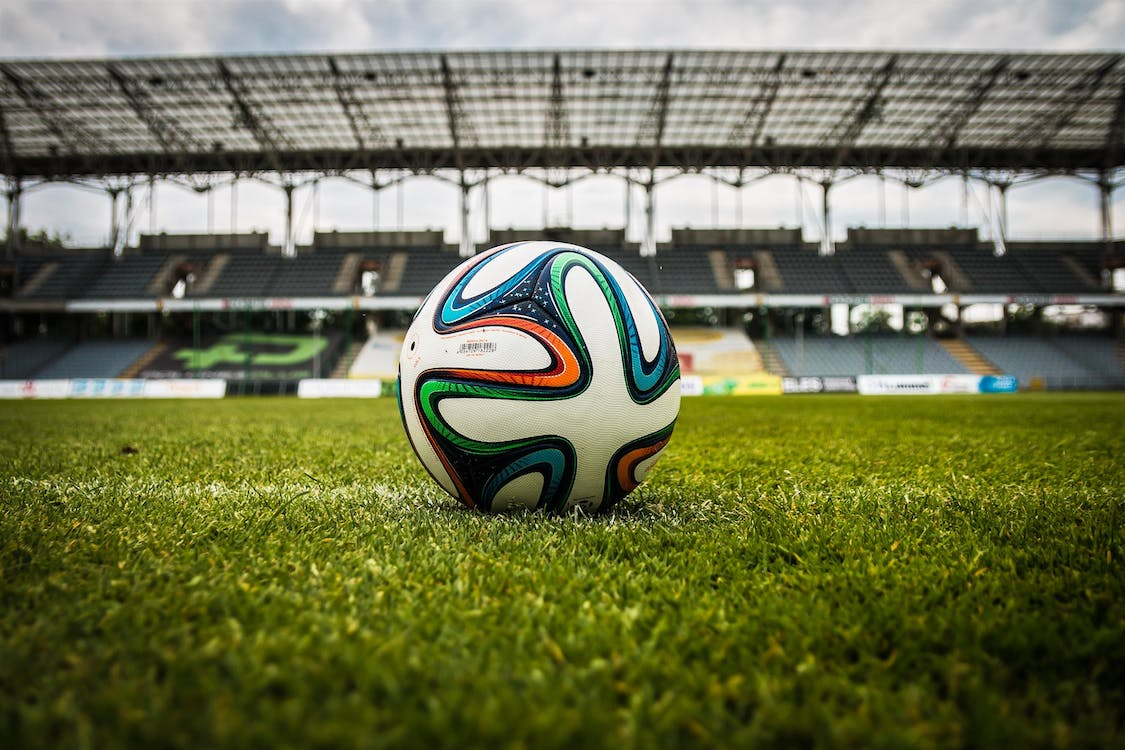

Tenemos los datos de:

- SQLite - European Soccer Database:
https://www.kaggle.com/datasets/hugomathien/soccer

- FIFA Positions:
  - https://www.kaggle.com/datasets/stefanoleone992/fifa-22-complete-player-dataset?select=players_15.csv

  - https://www.kaggle.com/datasets/stefanoleone992/fifa-22-complete-player-dataset?select=players_16.csv

### 1. Librerias:

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, hamming_loss
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping
import os
from tensorflow.keras.models import load_model

### 2. Read Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### Importamos la base de datos de European Soccer de Kaggle:

In [ ]:
conn = sqlite3.connect('/content/gdrive/MyDrive/Master IA/ApProfund Projecte/database.sqlite')
df_tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
df_tables

name
0    sqlite_sequence
1  Player_Attributes
2             Player
3              Match
4             League
5            Country
6               Team
7    Team_Attributes

In [ ]:
df_match = pd.read_sql_query("SELECT * FROM Match", conn)
print(len(df_match))
df_match.head()

25979


id  country_id  league_id     season  stage                 date  \
0   1           1          1  2008/2009      1  2008-08-17 00:00:00   
1   2           1          1  2008/2009      1  2008-08-16 00:00:00   
2   3           1          1  2008/2009      1  2008-08-16 00:00:00   
3   4           1          1  2008/2009      1  2008-08-17 00:00:00   
4   5           1          1  2008/2009      1  2008-08-16 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  ...  \
0        492473              9987              9993               1  ...   
1        492474             10000              9994               0  ...   
2        492475              9984              8635               0  ...   
3        492476              9991              9998               5  ...   
4        492477              7947              9985               1  ...   

    SJA   VCH   VCD   VCA   GBH   GBD   GBA   BSH   BSD   BSA  
0  4.00  1.65  3.40  4.50  1.78  3.25  4.00  1.73  3.40  4.20  
1  3.80  2.00  3.25  3.25  1.85  3.25  3.75  1.91  3.25  3.60  
2  2.50  2.35  3.25  2.65  2.50  3.20  2.50  2.30  3.20  2.75  
3  7.50  1.45  3.75  6.50  1.50  3.75  5.50  1.44  3.75  6.50  
4  1.73  4.50  3.40  1.65  4.50  3.50  1.65  4.75  3.30  1.67  

[5 rows x 115 columns]

#### Importamos las estadísticas de los jugadores:

In [ ]:
df_player = pd.read_sql_query("SELECT * FROM Player", conn)
# Nos quedamos con el nombre del jugador, su api_id para unir los dataframes
# con su altura y su peso.
df_player = df_player[['player_api_id','player_name','height','weight']]
df_player_stats = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)

# Las estadísticas de los jugadores van por cada temporada, por esa razón hay
# bastante más datos de estadísticas que de jugadores.
print('Num Players:',len(df_player))
print('Num Players Stats:',len(df_player_stats))

Num Players: 11060
Num Players Stats: 183978


In [ ]:
# Unimos los datos
df_merged = pd.merge(df_player, df_player_stats, on='player_api_id')
data_na = df_merged.drop(['id','player_fifa_api_id','date'],axis=1)
data_na.sample(5)

player_api_id           player_name  height  weight  overall_rating  \
75202          187666  Jacques Zoua Daogari  185.42     185            67.0   
47853          134222         Edouard Butin  180.34     168            66.0   
83338           30630              Joe Cole  175.26     161            76.0   
158389         388456           Scott Brown  182.88     170            49.0   
5628           282470     Alejandro Pozuelo  170.18     139            70.0   

        potential preferred_foot attacking_work_rate defensive_work_rate  \
75202        78.0          right              medium              medium   
47853        75.0          right              medium              medium   
83338        76.0          right                high              medium   
158389       66.0          right              medium              medium   
5628         73.0          right                high              medium   

        crossing  ...  vision  penalties  marking  standing_tackle  \
75202       56.0  ...    57.0       51.0     35.0             49.0   
47853       59.0  ...    64.0       42.0     11.0             17.0   
83338       81.0  ...    81.0       65.0     34.0             33.0   
158389      45.0  ...    62.0       51.0     37.0             38.0   
5628        63.0  ...    71.0       66.0     22.0             24.0   

        sliding_tackle  gk_diving  gk_handling  gk_kicking  gk_positioning  \
75202             13.0        5.0         10.0        12.0            10.0   
47853             12.0        7.0         13.0        14.0             5.0   
83338             29.0        8.0          5.0        12.0            15.0   
158389            45.0       15.0         15.0        10.0             7.0   
5628              14.0       10.0          8.0        14.0            10.0   

        gk_reflexes  
75202          14.0  
47853           7.0  
83338           6.0  
158389         11.0  
5628            8.0  

[5 rows x 42 columns]

#### Importamos los datos del FIFA y nos quedamos con el nombre del jugador y su posición:

In [ ]:
data_fifa15 = pd.read_csv('/content/gdrive/MyDrive/Master IA/ApProfund Projecte/players_15.csv')
data_fifa15 = data_fifa15[['short_name','player_positions']]
data_fifa15 = data_fifa15.rename(columns={"short_name": "Name"})
data_fifa15 = data_fifa15.rename(columns={"player_positions": "Position"})
print('Total de datos:',len(data_fifa15))
data_fifa15.head()

Total de datos: 15465


Name    Position
0           L. Messi          CF
1  Cristiano Ronaldo      LW, LM
2          A. Robben  RM, LM, RW
3     Z. Ibrahimović          ST
4           M. Neuer          GK

In [ ]:
data_fifa16 = pd.read_csv('/content/gdrive/MyDrive/Master IA/ApProfund Projecte/players_16.csv')
data_fifa16 = data_fifa16[['short_name','player_positions']]
data_fifa16 = data_fifa16.rename(columns={"short_name": "Name"})
data_fifa16 = data_fifa16.rename(columns={"player_positions": "Position"})
print('Total de datos:',len(data_fifa16))
data_fifa16.head()

Total de datos: 14881


Name    Position
0           L. Messi      RW, CF
1  Cristiano Ronaldo      LW, LM
2          A. Robben  RM, LM, RW
3           M. Neuer          GK
4          L. Suárez          ST

### 3. Data Cleaning:

In [ ]:
print('Antes de eliminar valores incorrectos:',len(data_na))

# Eliminamos valores que no corresponden a los valores que deberian tener
# las columnas defensive_work_rate y attacking_work_rate que deben ser
# medium, high y low.

a = ['_0', None, '5', 'ean', 'o', '1', 'ormal',
       '7', '2', '8', '4', 'tocky', '0', '3', '6', '9', 'es']

b = [None, 'None', 'le', 'norm', 'stoc', 'y']

data_na = data_na[~data_na['defensive_work_rate'].isin(a)]
data_na = data_na[~data_na['attacking_work_rate'].isin(b)]
print('Después de eliminar valores incorrectos:',len(data_na))

Antes de eliminar valores incorrectos: 183978
Después de eliminar valores incorrectos: 176161


In [ ]:
print('Antes de eliminar valores nulos:',len(data_na))
data = data_na.dropna(axis=0)
print('Después de eliminar valores nulos:',len(data_na))

Antes de eliminar valores nulos: 176161
Después de eliminar valores nulos: 176161


In [ ]:
# Trasnformando valores a numérico.
data_ok = data.replace({'low': int(0), 'medium': int(1), 'high': int(2)})
data_ok_ = data_ok.replace({'left': int(0), 'right': int(1)})

#### Transformando por la media:
Ahora vamos a transformar los datos de cada temporada de un jugador a la media de sus estadísticas por temporada:

In [ ]:
print('Con cada temporada:',len(data_ok_))

df_mean = data_ok_.groupby(['player_name'],as_index=False).mean()
print('Con la media:',len(df_mean))

Con cada temporada: 176161
Con la media: 9757


### Unir la posición del jugador de la BD de FIFA

Ahora vamos a incorporar la posición del jugador a aquellos jugadores que si estén en la BD del FIFA. Para ello, transformamos los nombres con la inicial junto a su apellido; ya que, en la BD del FIFA, lo tenemos de esta forma.

In [ ]:
def Change_names(df):
    player_names = list(df['player_name'].values)

    new_column = []
    for nombre in player_names:
        nombre_completo = nombre.split()

        if len(nombre_completo) == 1:
            new_column.append(nombre_completo[0])

        if len(nombre_completo) != 1:
            apellidos = nombre_completo[1:]
            apellidos = " ".join(apellidos)
            inicial = nombre_completo[0][0] + "."
            apellido_abreviado = inicial + " " + str(apellidos)
            new_column.append(apellido_abreviado)

    df = df.rename(columns={"player_name": "old_name"})
    df.insert(loc=0, column='Name', value=new_column)
    df = df.drop(['old_name'], axis=1)
    print('Numero de datos totales', len(df))

    return df

df_changed = Change_names(data_ok_)

Numero de datos totales 176161


In [ ]:
df_fifa = pd.merge(data_fifa15, data_fifa16, on='Name', how='inner')
df_fifa = df_fifa.drop(['Position_x'],axis=1)
df_fifa = df_fifa.rename(columns={"Position_y": "Position"})
print('Jugadores con posición:',len(df_fifa))
df_fifa.head(7)

Jugadores con posición: 13044


Name    Position
0           L. Messi      RW, CF
1  Cristiano Ronaldo      LW, LM
2          A. Robben  RM, LM, RW
3     Z. Ibrahimović          ST
4           M. Neuer          GK
5          L. Suárez          ST
6          L. Suárez          LB

In [ ]:
# create a new column that counts the number of positions
df_fifa['Position_count'] = df_fifa['Position'].str.split(',').str.len()

# group by Name and get the index of the row with the max Position_count
idx = df_fifa.groupby('Name')['Position_count'].idxmin()

# filter dataframe by the idx
df_filtered = df_fifa.loc[idx]
df_filtered[df_filtered['Name'] == 'L. Messi']


Name Position  Position_count
0  L. Messi   RW, CF               2

In [ ]:
# drop the Position_count column
df_filtered_ = df_filtered.drop('Position_count', axis=1)

df_final = pd.merge(df_filtered_, df_changed, on='Name', how='right')
print('Datos Finales:',len(df_final))
df_final.head(6)

Datos Finales: 176161


Name Position  player_api_id  height  weight  overall_rating  \
0  A. Appindangoye      NaN         505942  182.88     187            67.0   
1  A. Appindangoye      NaN         505942  182.88     187            67.0   
2  A. Appindangoye      NaN         505942  182.88     187            62.0   
3  A. Appindangoye      NaN         505942  182.88     187            61.0   
4  A. Appindangoye      NaN         505942  182.88     187            61.0   
5     A. Cresswell       LB         155782  170.18     146            74.0   

   potential  preferred_foot  attacking_work_rate  defensive_work_rate  ...  \
0       71.0               1                    1                    1  ...   
1       71.0               1                    1                    1  ...   
2       66.0               1                    1                    1  ...   
3       65.0               1                    1                    1  ...   
4       65.0               1                    1                    1  ...   
5       76.0               0                    2                    1  ...   

   vision  penalties  marking  standing_tackle  sliding_tackle  gk_diving  \
0    54.0       48.0     65.0             69.0            69.0        6.0   
1    54.0       48.0     65.0             69.0            69.0        6.0   
2    54.0       48.0     65.0             66.0            69.0        6.0   
3    53.0       47.0     62.0             63.0            66.0        5.0   
4    53.0       47.0     62.0             63.0            66.0        5.0   
5    66.0       59.0     76.0             75.0            78.0       14.0   

   gk_handling  gk_kicking  gk_positioning  gk_reflexes  
0         11.0        10.0             8.0          8.0  
1         11.0        10.0             8.0          8.0  
2         11.0        10.0             8.0          8.0  
3         10.0         9.0             7.0          7.0  
4         10.0         9.0             7.0          7.0  
5          7.0         9.0             9.0         12.0  

[6 rows x 43 columns]

Numero de jugadores CON posición: 83762
Numero de jugadores SIN posición: 92399


(0.0, 100.0)

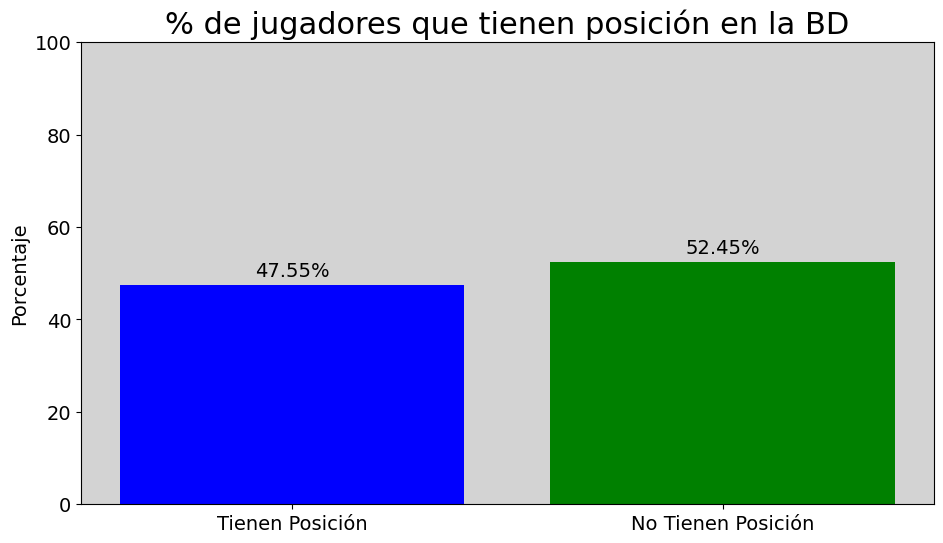

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(11,6)

# calculate percentage of null and non-null values
percent_not_null = df_final['Position'].notnull().sum() / len(df_final) * 100
percent_null = df_final['Position'].isnull().sum() / len(df_final) * 100

print('Numero de jugadores CON posición:',df_final['Position'].notnull().sum())
print('Numero de jugadores SIN posición:',df_final['Position'].isnull().sum())
# create a bar chart

bars = ax.bar(['Tienen Posición', 'No Tienen Posición'], [percent_not_null.mean(), percent_null.mean()], color=['blue', 'green'])

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                textcoords='offset points', ha='center', va='bottom', fontsize=14)

ax.set_title('% de jugadores que tienen posición en la BD', fontsize=22)
ax.set_ylabel('Porcentaje', fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_facecolor('lightgrey')
ax.set_ylim(0, 100)

### Duplicacar filas posiciones:
Como sabemos, hay jugadores que pueden jugar o estar asociados a mas de una posicion. Para ello, lo que vamos a hacer es poner tantas filas como posibles posiciones tiene un jugador

In [ ]:
df_positions = df_final.dropna()

In [ ]:
# Define a function to transform position values
def transform_position(positions):
    """
    This function transforms the given positions by replacing 'LWB' with 'RB', 'RWB' with 'RB', and 'CF' with 'ST'.
    """
    positions = positions.split(', ') # split multiple positions by comma and space
    positions = [p.replace('LWB', 'RB').replace('RWB', 'RB').replace('CF', 'ST') for p in positions] # transform values
    return ', '.join(positions) # join the transformed values with comma and space

# Apply the function to the 'Position' column
#df_positions['Position'] = df_positions['Position'].apply(transform_position)

In [ ]:
y_list = df_positions[['Name','Position']]

positions = y_list['Position'].str.get_dummies(sep=', ')
df_y = pd.concat([y_list['Name'], positions], axis=1)
df_y.head()

Name  CAM  CB  CDM  CF  CM  GK  LB  LM  LW  LWB  RB  RM  RW  RWB  \
5  A. Cresswell    0   0    0   0   0   0   1   0   0    0   0   0   0    0   
6  A. Cresswell    0   0    0   0   0   0   1   0   0    0   0   0   0    0   
7  A. Cresswell    0   0    0   0   0   0   1   0   0    0   0   0   0    0   
8  A. Cresswell    0   0    0   0   0   0   1   0   0    0   0   0   0    0   
9  A. Cresswell    0   0    0   0   0   0   1   0   0    0   0   0   0    0   

   ST  
5   0  
6   0  
7   0  
8   0  
9   0

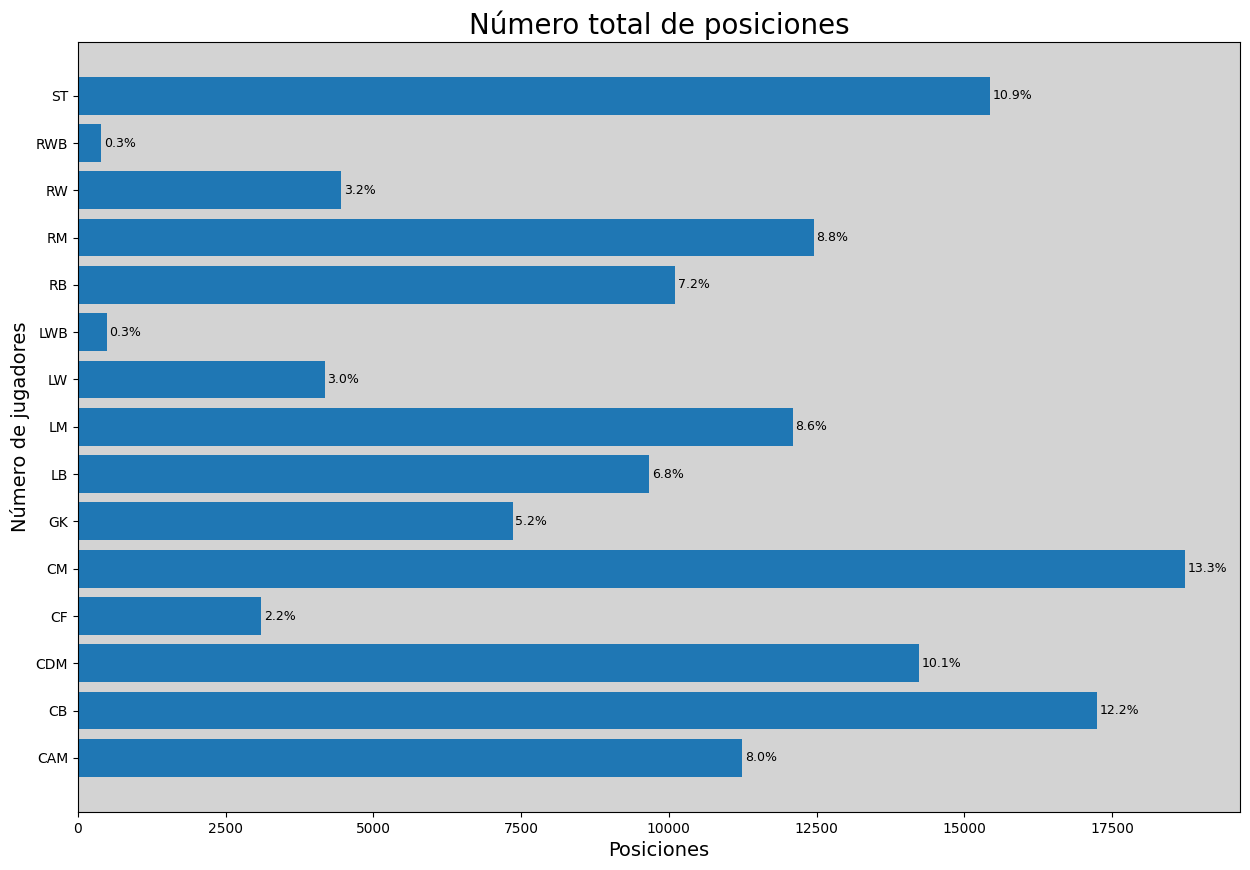

In [ ]:
# Creamos una lista llamada positions donde almacenaremos las posiciones
positions = []
for col in df_y.columns:
    if col != 'Name':
        positions.append(col)

# Creamos una lista llamada count_positions donde almacenaremos el número de jugadores por posición
count_positions = []
for pos in positions:
    count = df_y[pos].sum()
    count_positions.append(count)

# Creamos una figura
fig,ax = plt.subplots()
fig.set_size_inches(15,10)

ax.barh(positions, count_positions)
plt.title('Número total de posiciones',fontsize=20)
plt.xlabel('Posiciones',fontsize=14)
plt.ylabel('Número de jugadores',fontsize=14)

ax.set_facecolor('lightgrey')
# añadir porcentaje encima de cada barra
for i in ax.containers:
    ax.bar_label(i, label_type='edge', labels=[f"{h/sum(count_positions)*100:.1f}%" if h>0 else '' for h in i.datavalues], fontsize=9, padding=2)

plt.show()

### Split Data:

In [ ]:
y_name = df_positions['Name']
y_pos = df_y.drop(['Name'],axis=1)
y_api = df_positions['player_api_id']
X = df_positions.drop(['Name','Position','player_api_id'], axis=1)

In [ ]:
X.columns

Index(['height', 'weight', 'overall_rating', 'potential', 'preferred_foot',
       'attacking_work_rate', 'defensive_work_rate', 'crossing', 'finishing',
       'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve',
       'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration',
       'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power',
       'jumping', 'stamina', 'strength', 'long_shots', 'aggression',
       'interceptions', 'positioning', 'vision', 'penalties', 'marking',
       'standing_tackle', 'sliding_tackle', 'gk_diving', 'gk_handling',
       'gk_kicking', 'gk_positioning', 'gk_reflexes'],
      dtype='object')

**height**: Altura del jugador en centímetros (cm).

**weight**: Peso del jugador en kilogramos (kg).

**overall_rating**: Calificación general del jugador basada en su desempeño en los juegos de FIFA.

**potential**: Calificación potencial del jugador basada en su desempeño en los juegos de FIFA.

**preferred_foot**: Pie preferido del jugador (izquierdo o derecho).

**attacking_work_rate**: Tasa de trabajo ofensivo del jugador (baja, media o alta).

**defensive_work_rate**: Tasa de trabajo defensivo del jugador (baja, media o alta).

**crossing**: Atributo de cruce del jugador.

**finishing**: Atributo de finalización del jugador.

**heading_accuracy**: Atributo de precisión de cabeza del jugador.

**short_passing**: Atributo de pase corto del jugador.

**volleys**: Atributo de voleas del jugador.

**dribbling**: Atributo de regateo del jugador.

**curve**: Atributo de curva del jugador.

**free_kick_accuracy**: Atributo de precisión en tiros libres del jugador.

**long_passing**: Atributo de pase largo del jugador.

**ball_control**: Atributo de control de balón del jugador.

**acceleration**: Atributo de aceleración del jugador.

**sprint_speed**: Atributo de velocidad máxima del jugador.

**agility**: Atributo de agilidad del jugador.

**reactions**: Atributo de reacciones del jugador.

**balance**: Atributo de equilibrio del jugador.

**shot_power**: Atributo de potencia de tiro del jugador.

**jumping**: Atributo de salto del jugador.

**stamina**: Atributo de resistencia física del jugador.

**strength**: Atributo de fuerza física del jugador.

**long_shots**: Atributo de tiros largos del jugador.

**aggression**: Atributo de agresividad del jugador.

**interceptions**: Atributo de intercepciones defensivas del jugador.

**positioning**: Atributo posicional defensivo y ofensivo del jugador.

**vision**: Atributo visual y táctico ofensivo y defensivo del jugador.

**penalties**: Atributo penalizador y ejecutorio ofensivo y defensivo del jugador.

**marking**: Atributo defensivo y posicional para marcar al oponente directo con el balón (hombre a hombre).

**standing_tackle**: Tackleo parado defensivo y posicional para recuperar el balón sin cometer falta o tarjeta amarilla/roja.

**sliding_tackle**: Tackleo deslizante defensivo y posicional para recuperar el balón sin cometer falta o tarjeta amarilla/roja.


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_pos, test_size=0.2, random_state=42)

print('Longitud Train =',len(X_train))
print('Longitud Test =',len(X_test))

Longitud Train = 67009
Longitud Test = 16753


# Standarization:

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

#### Feature Engeneering:

Creating new features from the original data:

In [ ]:
def NewFeatures(X):
  # Creating New variables
  # Body Mass Index
  X['wh'] = (X['weight'] + X['height']) / 2.0

  # Overalll Rating and Potential
  X['performance_index'] = (X['overall_rating'] + X['potential']) /2.0

  # Finishing
  X["finishing_acc"] = (X["finishing"] + X["heading_accuracy"] + X["shot_power"])/3.0

  # Skills:
  X['skills'] = (X['crossing'] + X['dribbling'] + X['curve'] + X['ball_control']) / 3.0

  # Mentality
  X['mentality'] = (X['aggression'] + X['interceptions'] + X['positioning'] +  X['vision']) / 4.0

  # Movment
  X['movment'] = (X['acceleration'] + X['sprint_speed'] + X['agility']+
                  X['reactions'] + X['balance']) /5.0

  # AT Rates
  X['attacking_rating'] = (X['crossing'] + X['finishing'] + X['heading_accuracy'] +
                              X['short_passing'] + X['volleys']) / 5.0

  # MC Rates
  X['midfield_rating'] = (X['short_passing'] + X['long_passing'] + X['ball_control'] +
                            X['vision'] + X['crossing'] + X['curve'] + X['dribbling'] +
                            X['free_kick_accuracy'] + X['long_shots']) / 9.0
  # DEF Rates
  X['defensive_rating'] = (X['marking'] + X['standing_tackle'] + X['sliding_tackle']) / 3.0

  # GK Rates
  X['goalkeeper_rating'] = (X['gk_diving'] + X['gk_handling'] + X['gk_kicking'] +
                              X['gk_positioning'] + X['gk_reflexes']) / 5.0

  return X


In [ ]:
X_train_new = NewFeatures(X_train_df)
X_test_new = NewFeatures(X_test_df)
X_train_new.head()

height    weight  overall_rating  potential  preferred_foot  \
0  0.470588  0.239316        0.711864   0.655172             1.0   
1  0.352941  0.145299        0.525424   0.637931             0.0   
2  0.764706  0.452991        0.474576   0.517241             1.0   
3  0.294118  0.145299        0.762712   0.810345             1.0   
4  0.235294  0.051282        0.576271   0.637931             1.0   

   attacking_work_rate  defensive_work_rate  crossing  finishing  \
0                  0.5                  0.5  0.824176   0.677083   
1                  1.0                  0.5  0.725275   0.510417   
2                  0.5                  0.5  0.681319   0.656250   
3                  0.5                  0.5  0.659341   0.614583   
4                  1.0                  0.0  0.714286   0.614583   

   heading_accuracy  ...        wh  performance_index  finishing_acc  \
0          0.548387  ...  0.354952           0.683518       0.656717   
1          0.537634  ...  0.249120           0.581677       0.583393   
2          0.580645  ...  0.608849           0.495909       0.621518   
3          0.784946  ...  0.219708           0.786528       0.728921   
4          0.344086  ...  0.143288           0.607101       0.532322   

     skills  mentality   movment  attacking_rating  midfield_rating  \
0  1.108652   0.688360  0.749753          0.683215         0.800369   
1  0.888145   0.551524  0.752839          0.582230         0.600636   
2  0.750033   0.513168  0.695254          0.606858         0.509967   
3  0.884223   0.805713  0.798611          0.706620         0.693216   
4  0.988761   0.502064  0.810110          0.601967         0.692679   

   defensive_rating  goalkeeper_rating  
0          0.429110           0.111332  
1          0.644736           0.084023  
2          0.714595           0.096965  
3          0.857824           0.095312  
4          0.315669           0.098953  

[5 rows x 50 columns]

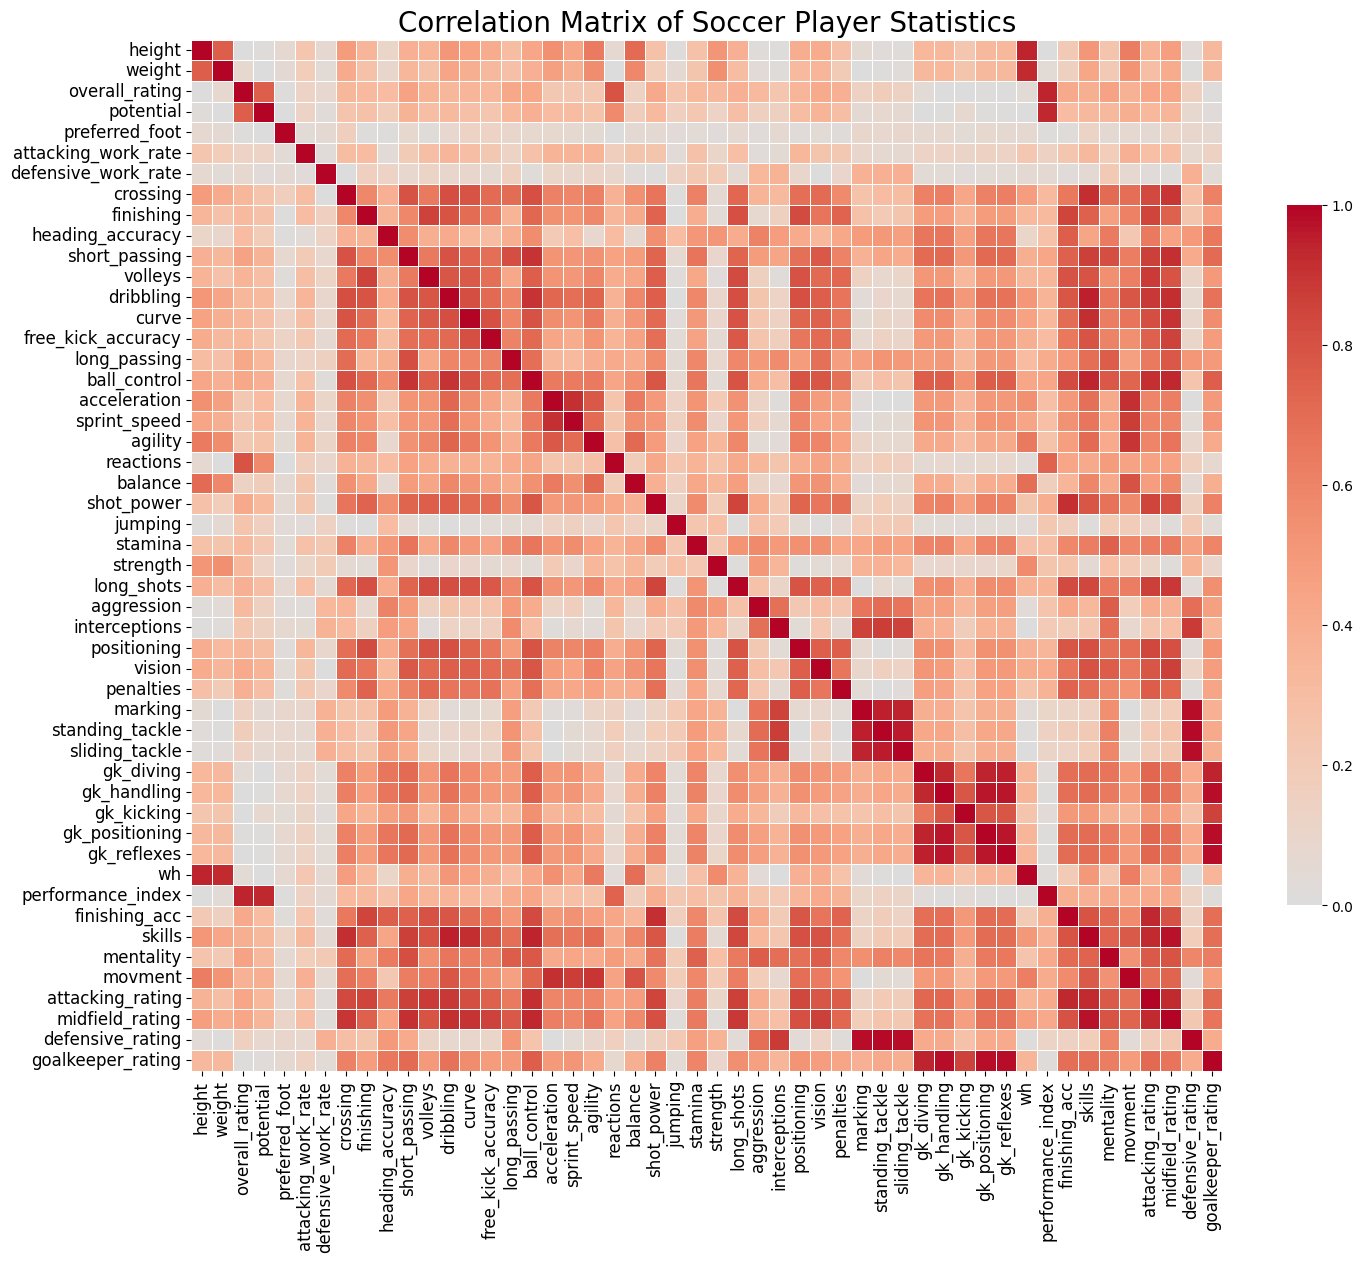

In [ ]:
# Select the columns to include in the correlation matrix
cols = list(X_train_new.columns)

# Create a correlation matrix
corr = abs(X_train_new[cols].corr())

# Create a heatmap using seaborn
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt='.2f', vmin=0, vmax=1,
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot_kws={"fontsize":9})
ax.set_xticklabels(cols, rotation=90, fontsize=12)
ax.set_yticklabels(cols, rotation=0, fontsize=12)
plt.title("Correlation Matrix of Soccer Player Statistics", fontsize=20)
plt.tight_layout()
plt.show()

### Variables más importantes:

In [ ]:
X_train = np.array(X_train_new)
X_test = np.array(X_test_new)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
X_train.shape


(67009, 50)

#### Con una Red Neuronal:

In [ ]:
# Create directory if it doesn't exist
directory = '/content/gdrive/MyDrive/Master IA/ApProfund Projecte/Models/'
if not os.path.exists(directory):
    os.makedirs(directory)

#### Train the model:

In [ ]:
# Build a neural network to predict the positions
Zlatanizer = tf.keras.Sequential([
    Dense(256, activation='elu', input_dim=X_train.shape[1]),
    Dropout(0.15),
    Dense(512, activation='elu'),
    Dropout(0.15),
    Dense(256, activation='elu'),
    Dropout(0.15),
    Dense(128, activation='elu'),
    Dropout(0.1),
    Dense(64, activation='elu'),
    Dropout(0.1),
    Dense(y_train.shape[1], activation='sigmoid')
])


# Compilar el modelo
Zlatanizer.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=400, verbose=1, mode='min', restore_best_weights=True)

# Entrenar el modelo
history = Zlatanizer.fit(X_train, y_train, epochs=20000, batch_size=256, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/20000
262/262 [==============================] - 12s 34ms/step - loss: 0.2487 - accuracy: 0.4310 - val_loss: 0.1941 - val_accuracy: 0.5284
Epoch 2/20000
262/262 [==============================] - 7s 27ms/step - loss: 0.2033 - accuracy: 0.5157 - val_loss: 0.1880 - val_accuracy: 0.5415
Epoch 3/20000
262/262 [==============================] - 9s 35ms/step - loss: 0.1980 - accuracy: 0.5249 - val_loss: 0.1862 - val_accuracy: 0.5376
Epoch 4/20000
262/262 [==============================] - 7s 27ms/step - loss: 0.1953 - accuracy: 0.5292 - val_loss: 0.1855 - val_accuracy: 0.5551
Epoch 5/20000
262/262 [==============================] - 12s 44ms/step - loss: 0.1936 - accuracy: 0.5307 - val_loss: 0.1832 - val_accuracy: 0.5480
Epoch 6/20000
262/262 [==============================] - 9s 33ms/step - loss: 0.1920 - accuracy: 0.5328 - val_loss: 0.1829 - val_accuracy: 0.5481
Epoch 7/20000
262/262 [==============================] - 7s 28ms/step - loss: 0.1908 - accuracy: 0.5366 - val_loss: 0.1810

In [ ]:
Zlatanizer.save(directory + 'Zlatanizer.h5')

In [ ]:
# create figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# plot loss on first subplot
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss over Epochs', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.legend(fontsize=14)
# plot accuracy on second subplot
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Accuracy over Epochs', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_ylabel('Accuracy', fontsize=14)
ax2.legend(fontsize=14)

# display the plot
plt.show()

#### Load the model:

In [ ]:
# Load the model
Zlatanizer = load_model(directory + 'Zlatanizer.h5')

#### Predictions and Analysis of results:

In [ ]:
 # Predict positions for test set
y_pred = Zlatanizer.predict(X_test)

524/524 [==============================] - 2s 4ms/step


In [ ]:
# Define a range of thresholds to try
threshold_range = np.arange(0.1, 1.0, 0.05)

# Evaluate performance for each threshold
f1_scores = []
for threshold in threshold_range:
    # transform the predictions to binary values based on the threshold
    y_pred_binary = np.where(y_pred > threshold, 1, 0)
    # Calculate F1 score
    f1 = f1_score(y_test, y_pred_binary, average='weighted')
    f1_scores.append(f1)

# Find the threshold with the highest F1 score
optimal_threshold = threshold_range[np.argmax(f1_scores)]
print("Optimal threshold:", optimal_threshold)

Optimal threshold: 0.5500000000000002


In [ ]:
# transform the predictions to binary values based on the threshold
y_pred_binary = np.where(y_pred > optimal_threshold, 1, 0)
# Evaluate performance:
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy: {:.2f}".format(accuracy))
f1 = f1_score(y_test, y_pred_binary, average='weighted')
print("F1 Score: {:.2f}".format(f1))

Accuracy: 0.98
F1 Score: 0.99


In [ ]:
# transform the predictions to binary values based on the threshold
 # Predict positions for test set
y_pred_train = Zlatanizer.predict(X_train)

y_pred_train = np.where(y_pred_train > optimal_threshold, 1, 0)
# Evaluate performance:
accuracy = accuracy_score(y_train, y_pred_train)
print("Accuracy: {:.2f}".format(accuracy))
f1 = f1_score(y_train, y_pred_train, average='weighted')
print("F1 Score: {:.2f}".format(f1))

2095/2095 [==============================] - 5s 2ms/step
Accuracy: 1.00
F1 Score: 1.00


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


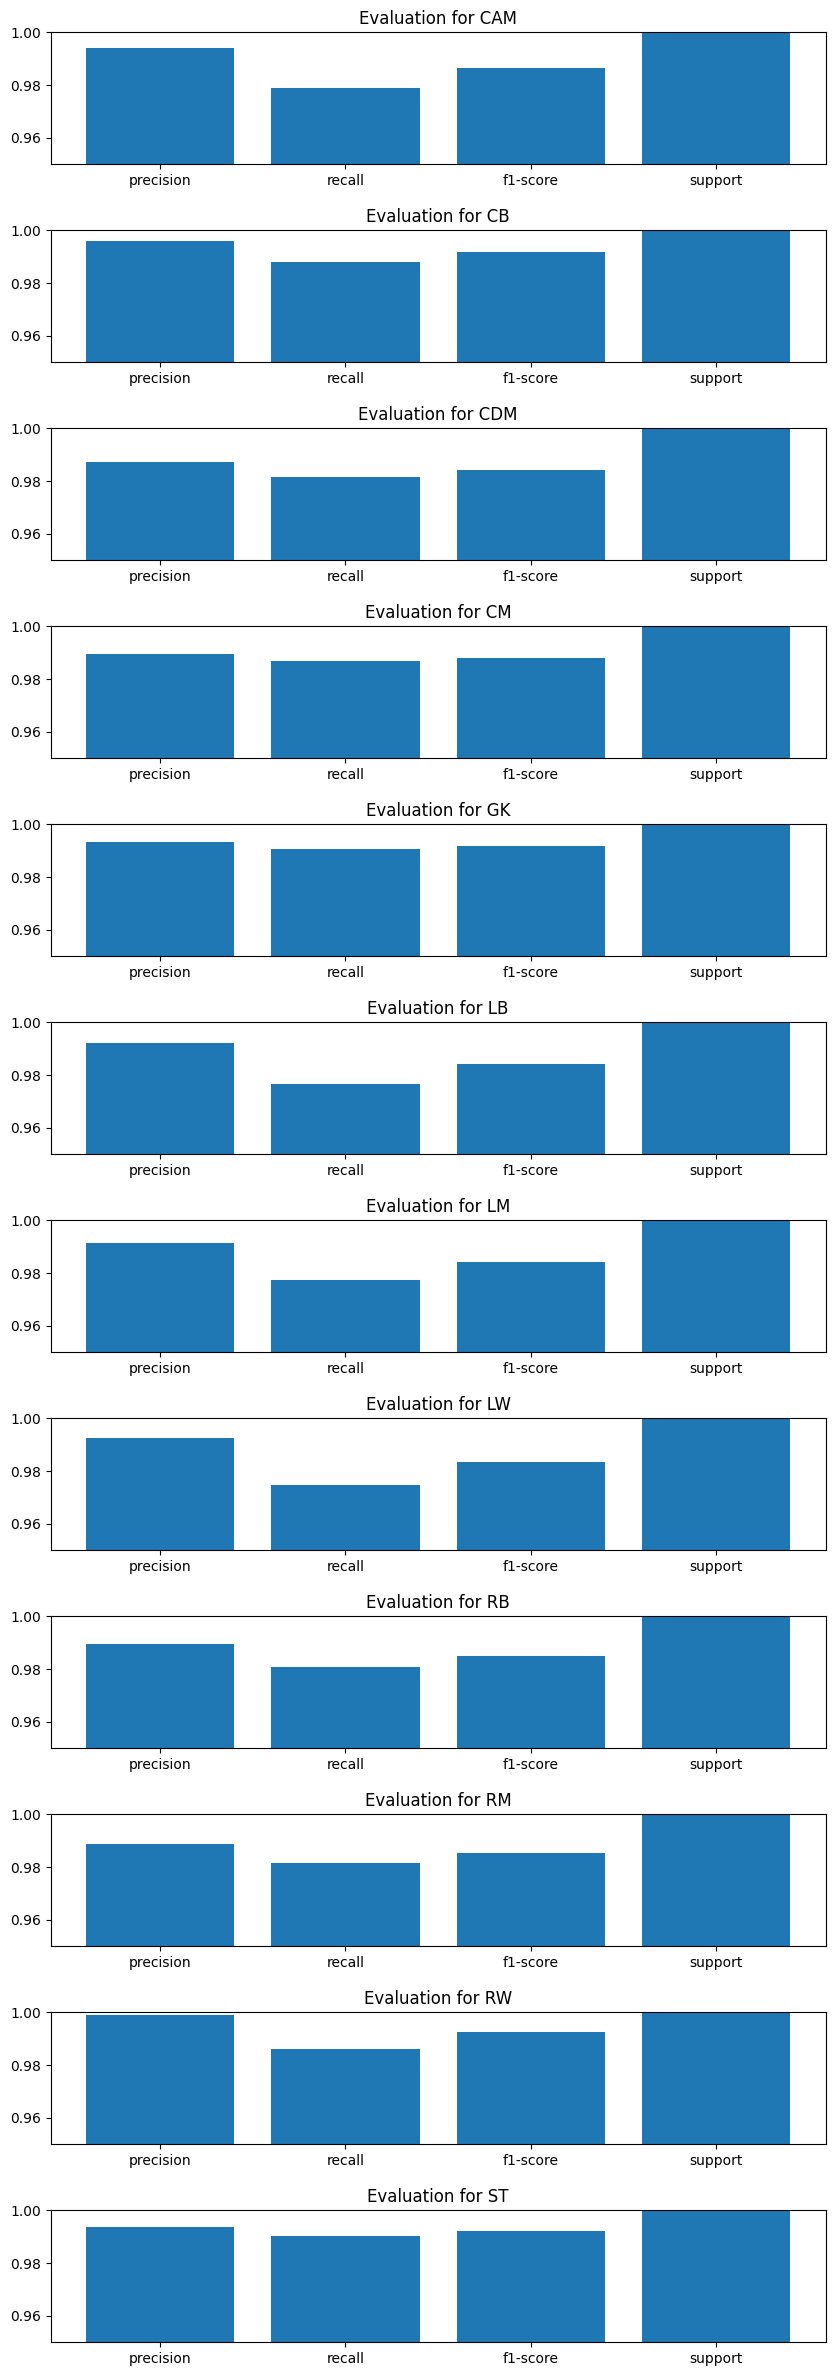

In [ ]:
# Generate classification report
report = classification_report(y_test, y_pred_binary, target_names=y_pos.columns, output_dict=True)

# Create subplots
fig, axes = plt.subplots(nrows=len(y_pos.columns), ncols=1, figsize=(10, 30))
plt.subplots_adjust(hspace=0.5)

# Loop through each position and plot its evaluation metrics
for i, position in enumerate(y_pos.columns):
    metrics = ['precision', 'recall', 'f1-score', 'support']
    values = [report[position][m] for m in metrics]

    axes[i].bar(metrics, values)
    axes[i].set_title(f'Evaluation for {position}')
    axes[i].set_ylim([0.95, 1])

plot_name = os.path.join(directory, 'ZlatanizerPredictions.png')
plt.savefig(plot_name, bbox_inches='tight')
plt.show()

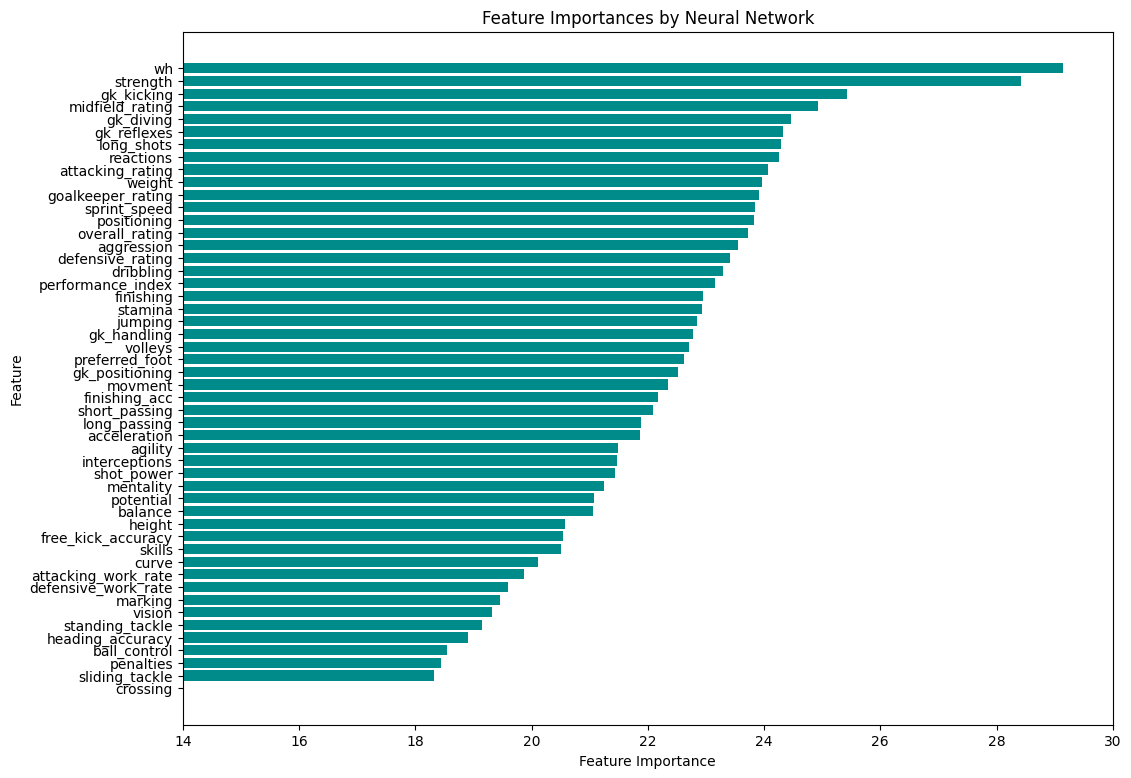

<Figure size 640x480 with 0 Axes>

In [ ]:
# Get the weights of the neural network
weights = Zlatanizer.get_weights()

features = list(X_train_new.columns)
# Get the feature importances
importances = weights[0]
feature_total_importances = []
for i in range(len(features)):
    importance = sum(abs(importances[:, i]))
    feature_total_importances.append((features[i], importance))

# Sort the feature importances in descending order
feature_total_importances = sorted(feature_total_importances, key=lambda x: x[1], reverse=True)


# Create a horizontal bar chart of feature importances
fig, ax = plt.subplots(figsize=(12, 9))
ax.barh(range(len(feature_total_importances)), [imp[1] for imp in feature_total_importances], color='darkcyan', align='center')
ax.set_yticks(range(len(feature_total_importances)))
ax.set_yticklabels([imp[0] for imp in feature_total_importances])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importances by Neural Network')
ax.set_xlim(14,30)
plt.show()

plot_name = os.path.join(directory, 'ImportanciasTotales.png')
plt.savefig(plot_name, bbox_inches='tight')

El equilibrio, el regate, la velocidad de sprint y la colocación están relacionados con los atributos físicos y las habilidades técnicas del jugador, que son factores importantes para determinar su rendimiento en el juego.

El manejo del balón es una característica importante para los guardametas, ya que está relacionada con su capacidad para atrapar y controlar el balón.

La visión y la interceptación son características importantes para los centrocampistas y los defensas, respectivamente, ya que están relacionadas con su capacidad para leer el juego y anticiparse a los movimientos del rival.

La resistencia y la habilidad son características importantes para todos los jugadores, ya que están relacionadas con su forma física general y su capacidad técnica.

La entrada deslizante es una característica importante para los defensas, ya que está relacionada con su capacidad para realizar entradas eficaces y recuperar la posesión del balón.


In [ ]:
class_names = y_pos.columns.values

# Get the weights of the first layer of the model
weights = Zlatanizer.get_weights()[0]
# Get the list of feature names
feature_names = list(X_train_new.columns)
# Get the number of classes
num_classes = y_train.shape[1]
# Initialize the feature importances dictionary
feature_importances = {}
# Iterate over the classes
for i in range(num_classes):
    # Get the importances for the current class
    importances = weights[:, i]
    # Sort the importances by absolute value in descending order
    sorted_indices = np.argsort(np.abs(importances))[::-1]
    # Get the sorted feature names and importances
    sorted_feature_names = [feature_names[j] for j in sorted_indices]
    sorted_importances = [importances[j] for j in sorted_indices]
    # Add the feature importances to the dictionary
    feature_importances[class_names[i]] = (sorted_feature_names, sorted_importances)

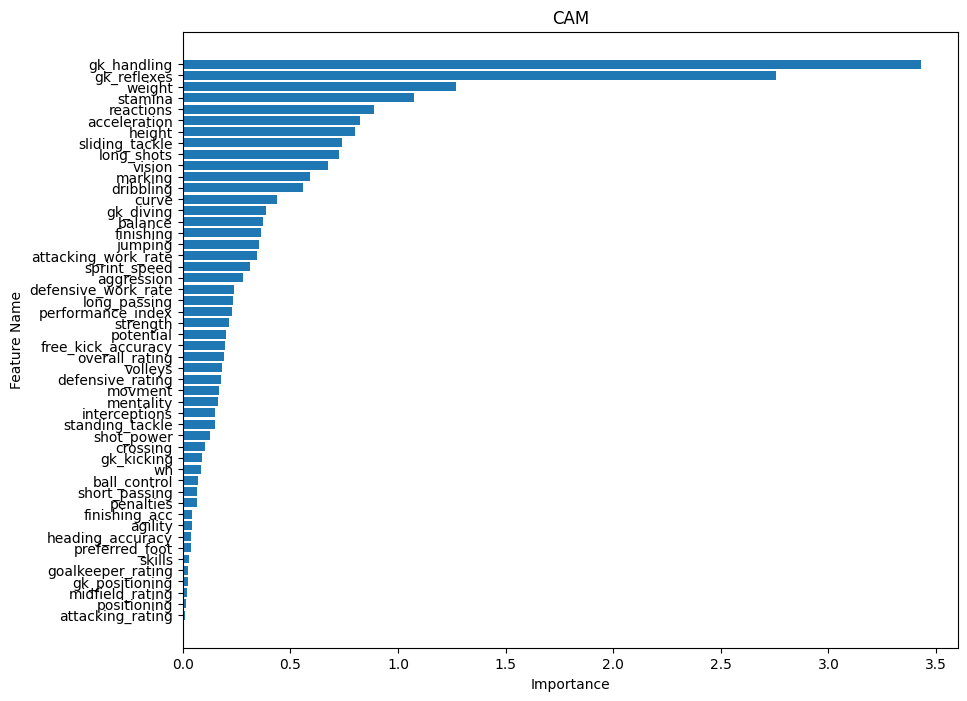

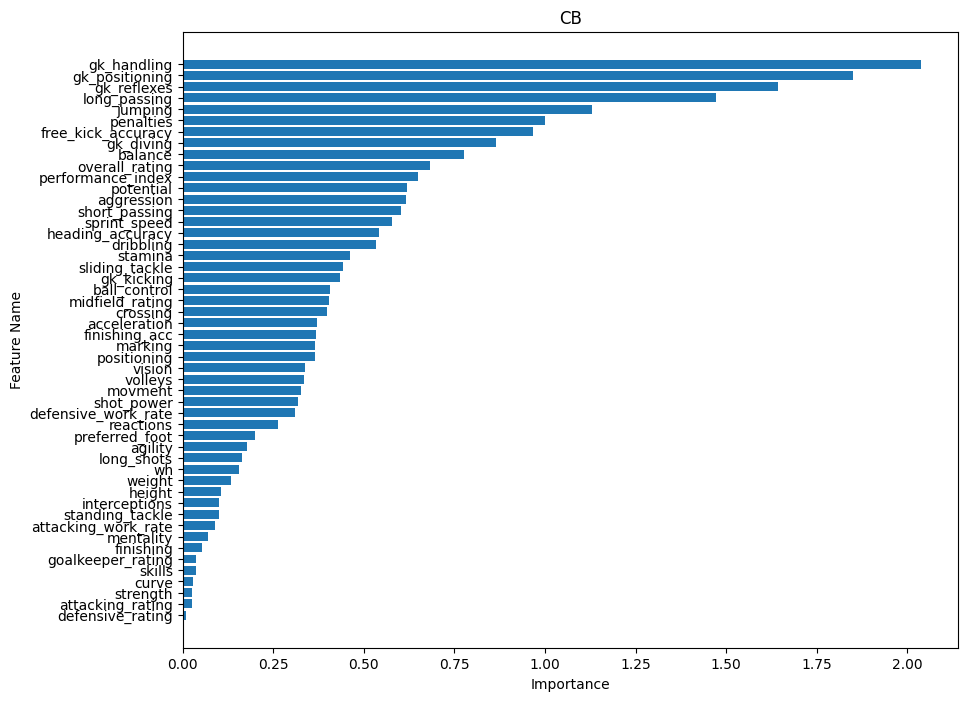

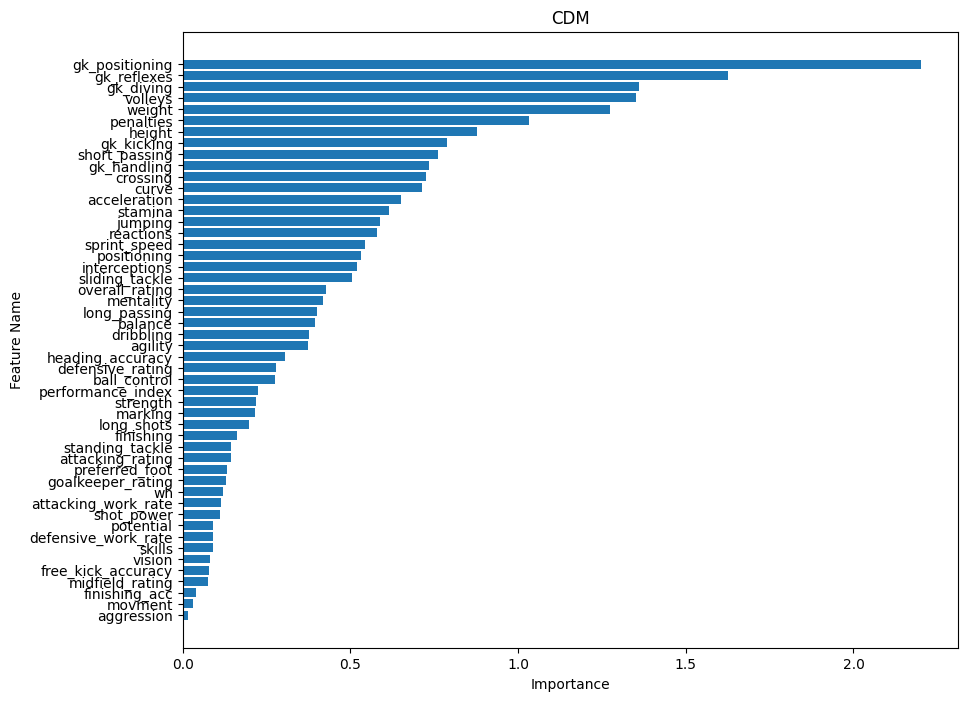

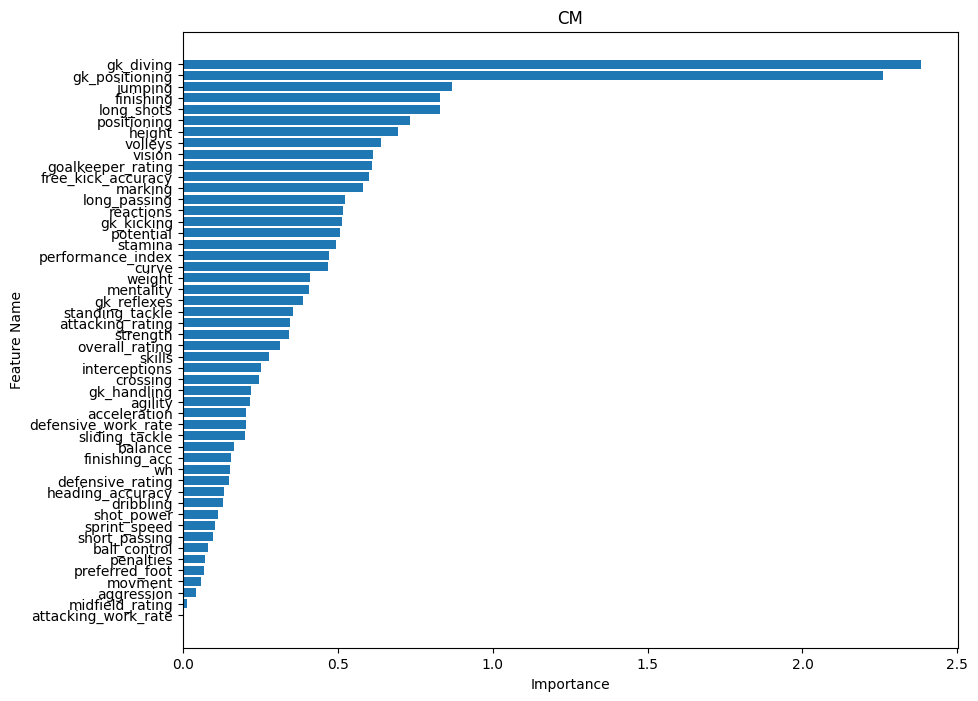

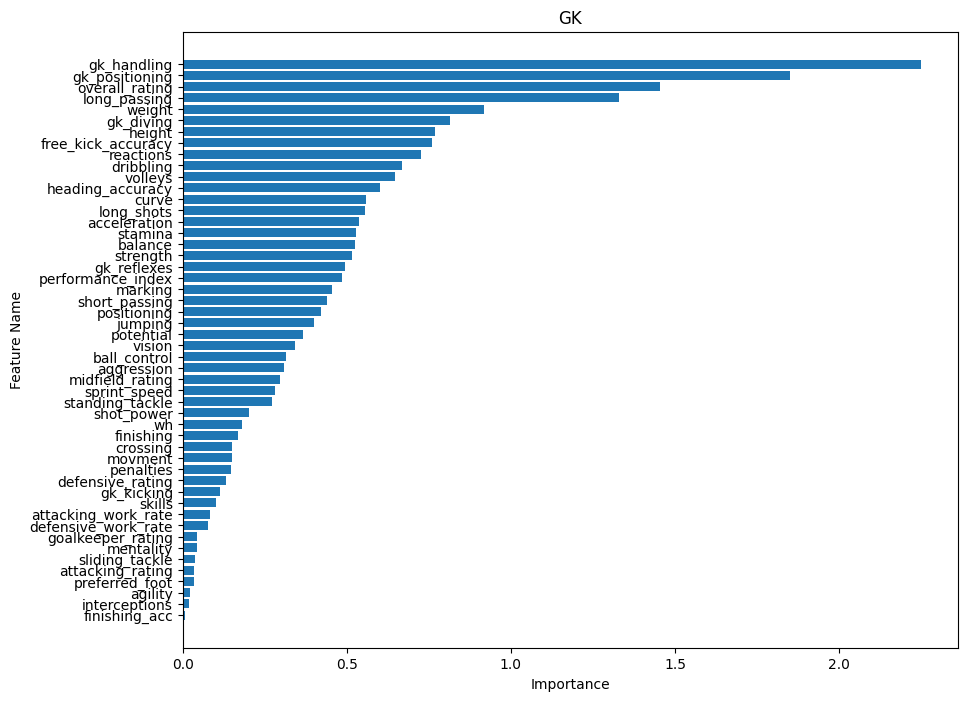

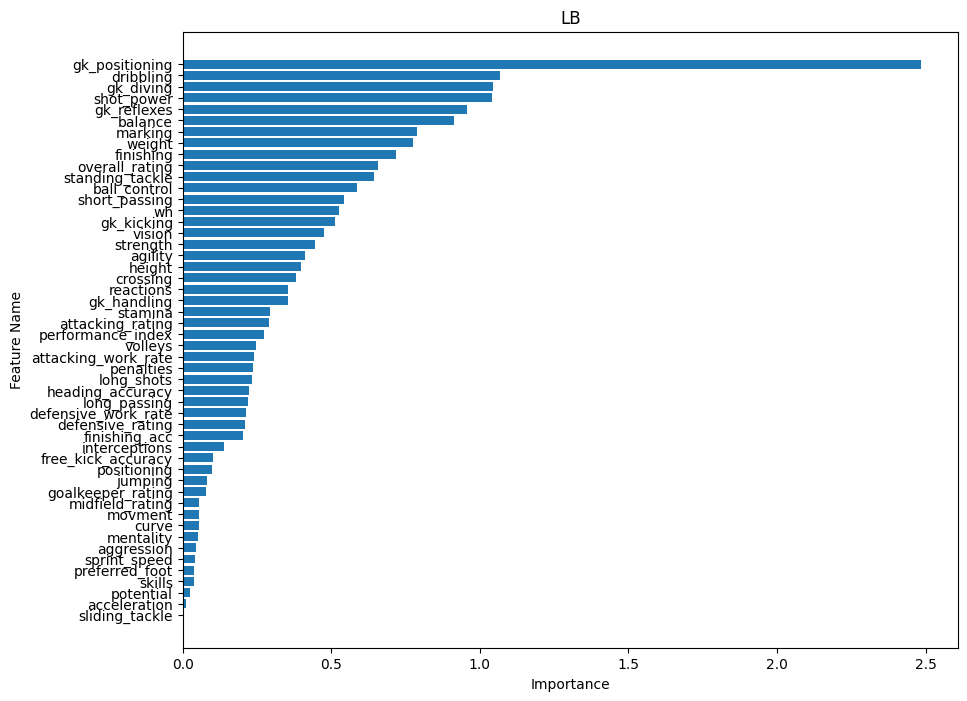

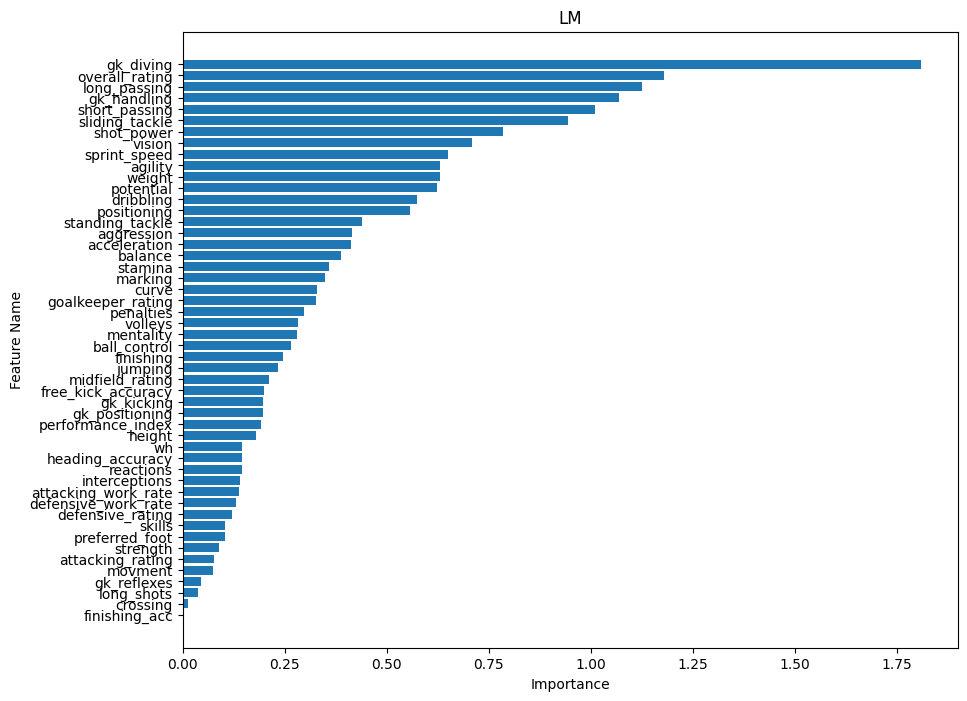

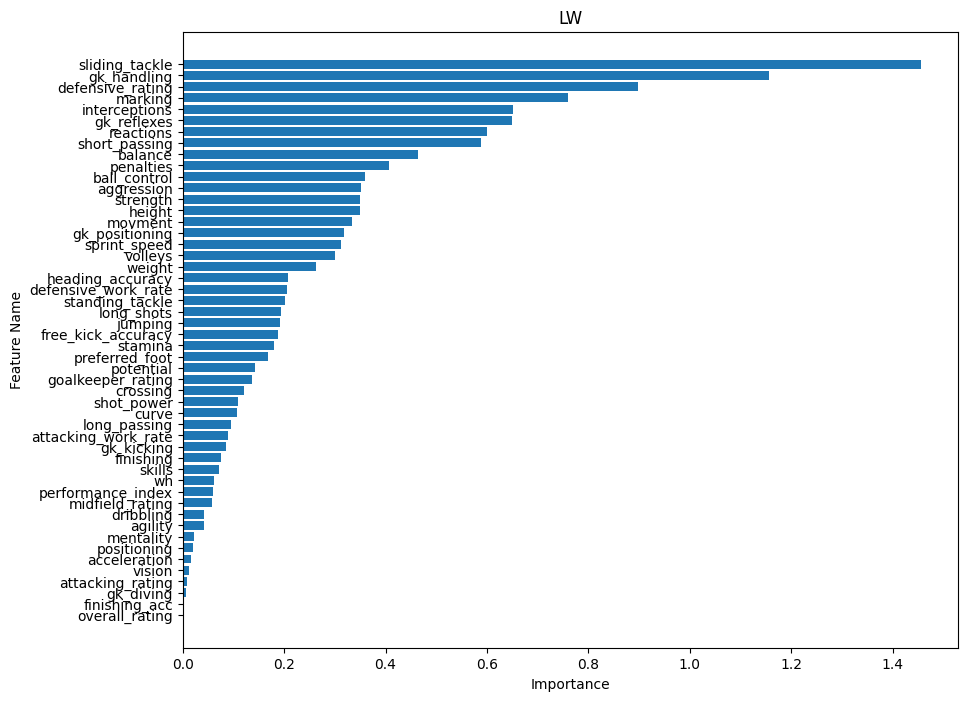

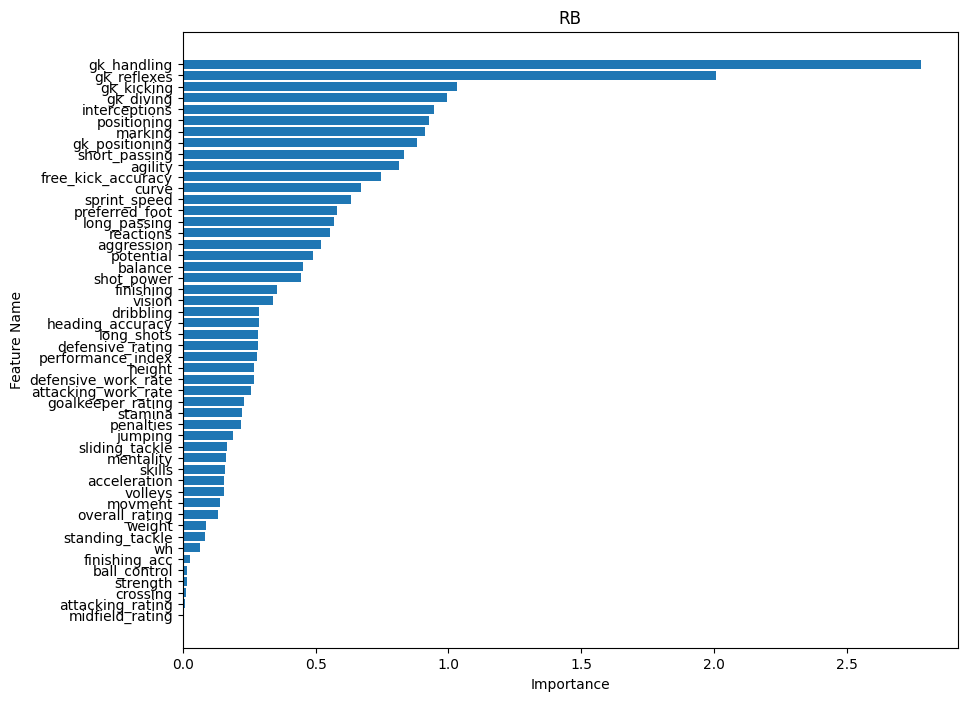

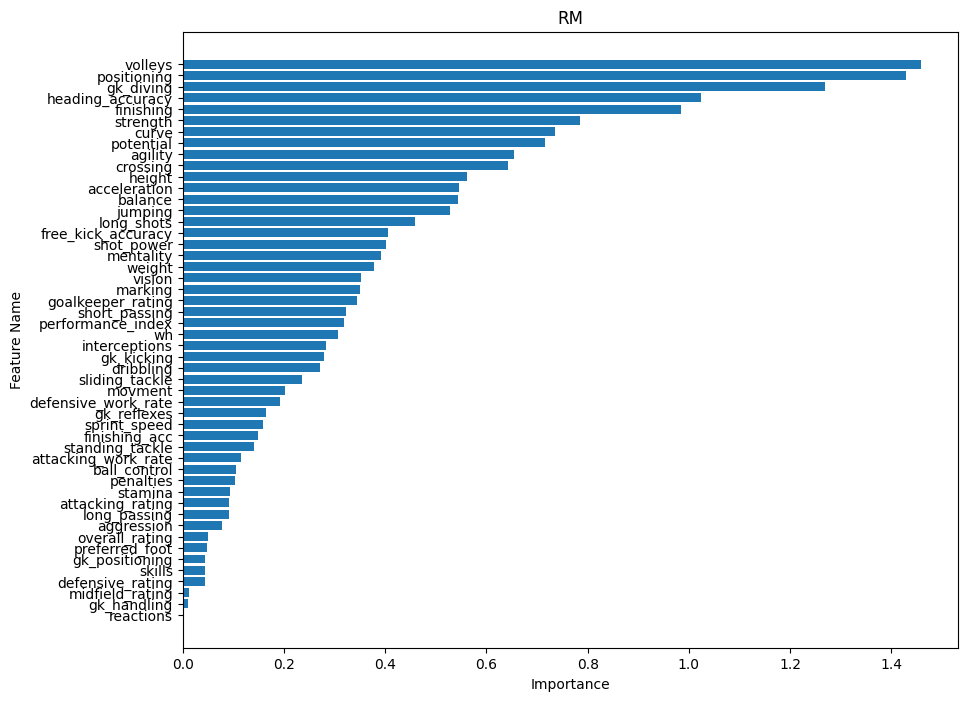

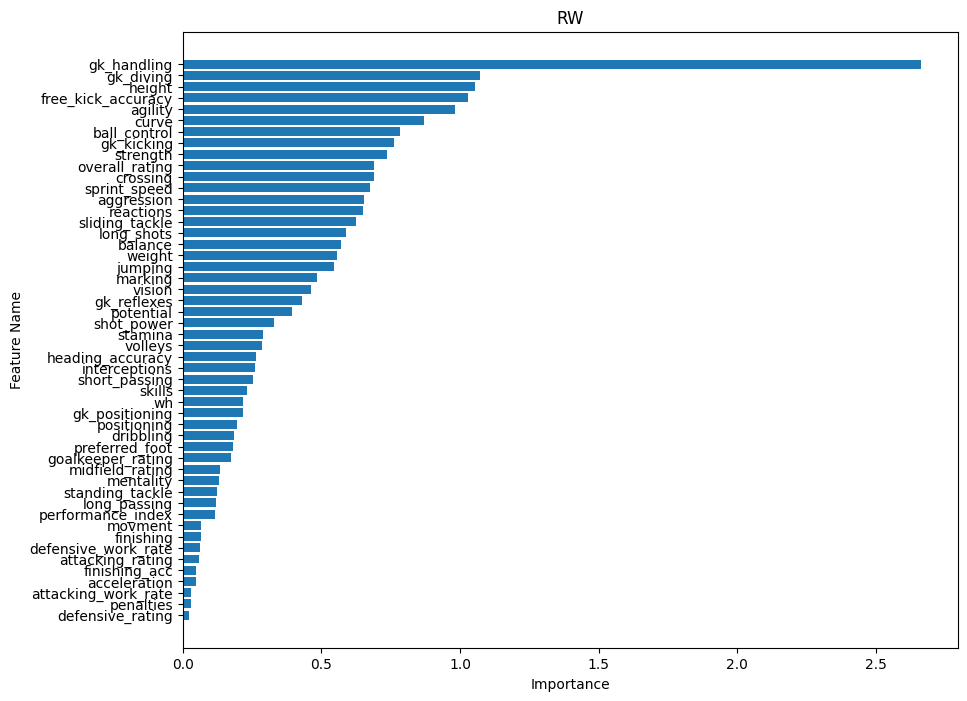

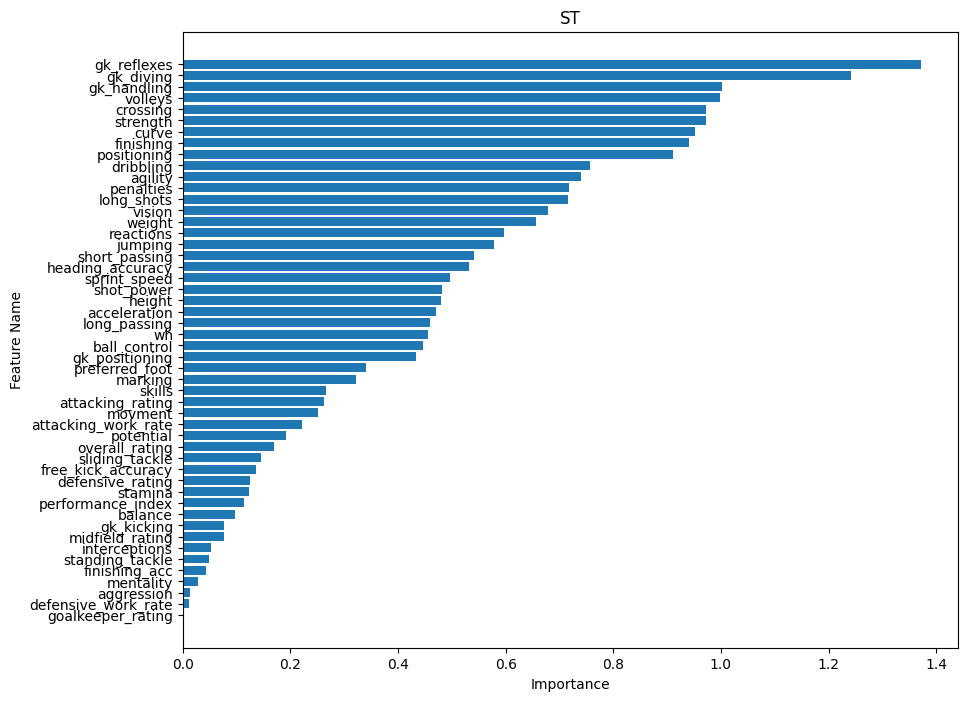

In [ ]:
# Iterate through all positions
for position in feature_importances.keys():
    # Get the sorted feature names and importances for the position
    sorted_feature_names, sorted_importances = feature_importances[position]

    # Create a subplot for the position
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(sorted_feature_names, np.abs(sorted_importances))
    ax.set_title(str(position))
    ax.set_xlabel('Importance')
    ax.set_ylabel('Feature Name')
    ax.invert_yaxis()
    plt.show()

    # Create folder if it doesn't exist
    folder_name = directory + 'PosPlots/'
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # Save plot with position name as the filename
    plot_name = os.path.join(folder_name, f'{position}.png')
    plt.savefig(plot_name, bbox_inches='tight')

    # Close the plot to free up memory
    plt.close()

### Creating a dataframe Positions:

In [ ]:
df_pos = pd.concat([y_name, X],axis=1)
df_pos_final = pd.concat([df_pos,y_pos],axis=1)
df_pos_final

Name  height  weight  overall_rating  potential  \
5       A. Cresswell  170.18     146            74.0       76.0   
6       A. Cresswell  170.18     146            74.0       76.0   
7       A. Cresswell  170.18     146            73.0       75.0   
8       A. Cresswell  170.18     146            73.0       75.0   
9       A. Cresswell  170.18     146            73.0       75.0   
...              ...     ...     ...             ...        ...   
176117     Z. Feddal  190.50     172            62.0       66.0   
176118     Z. Feddal  190.50     172            62.0       66.0   
176119     Z. Feddal  190.50     172            62.0       66.0   
176120     Z. Feddal  190.50     172            62.0       66.0   
176121     Z. Feddal  190.50     172            62.0       66.0   

        preferred_foot  attacking_work_rate  defensive_work_rate  crossing  \
5                    0                    2                    1      80.0   
6                    0                    2                    1      80.0   
7                    0                    2                    1      79.0   
8                    0                    2                    1      79.0   
9                    0                    2                    1      79.0   
...                ...                  ...                  ...       ...   
176117               0                    1                    1      45.0   
176118               0                    0                    1      45.0   
176119               0                    0                    1      45.0   
176120               0                    0                    1      45.0   
176121               0                    0                    1      45.0   

        finishing  ...  CDM  CM  GK  LB  LM  LW  RB  RM  RW  ST  
5            53.0  ...    0   0   0   1   0   0   0   0   0   0  
6            53.0  ...    0   0   0   1   0   0   0   0   0   0  
7            52.0  ...    0   0   0   1   0   0   0   0   0   0  
8            51.0  ...    0   0   0   1   0   0   0   0   0   0  
9            51.0  ...    0   0   0   1   0   0   0   0   0   0  
...           ...  ...  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  
176117       25.0  ...    0   0   0   1   0   0   0   0   0   0  
176118       25.0  ...    0   0   0   1   0   0   0   0   0   0  
176119       25.0  ...    0   0   0   1   0   0   0   0   0   0  
176120       25.0  ...    0   0   0   1   0   0   0   0   0   0  
176121       25.0  ...    0   0   0   1   0   0   0   0   0   0  

[83762 rows x 53 columns]

In [ ]:
df_final

Name Position  player_api_id  height  weight  \
0       A. Appindangoye      NaN         505942  182.88     187   
1       A. Appindangoye      NaN         505942  182.88     187   
2       A. Appindangoye      NaN         505942  182.88     187   
3       A. Appindangoye      NaN         505942  182.88     187   
4       A. Appindangoye      NaN         505942  182.88     187   
...                 ...      ...            ...     ...     ...   
176156     Z. Misimovic      NaN          39902  180.34     176   
176157     Z. Misimovic      NaN          39902  180.34     176   
176158     Z. Misimovic      NaN          39902  180.34     176   
176159     Z. Misimovic      NaN          39902  180.34     176   
176160     Z. Misimovic      NaN          39902  180.34     176   

        overall_rating  potential  preferred_foot  attacking_work_rate  \
0                 67.0       71.0               1                    1   
1                 67.0       71.0               1                    1   
2                 62.0       66.0               1                    1   
3                 61.0       65.0               1                    1   
4                 61.0       65.0               1                    1   
...                ...        ...             ...                  ...   
176156            83.0       85.0               1                    1   
176157            78.0       80.0               1                    1   
176158            77.0       80.0               1                    1   
176159            78.0       81.0               1                    1   
176160            80.0       81.0               1                    1   

        defensive_work_rate  ...  vision  penalties  marking  standing_tackle  \
0                         1  ...    54.0       48.0     65.0             69.0   
1                         1  ...    54.0       48.0     65.0             69.0   
2                         1  ...    54.0       48.0     65.0             66.0   
3                         1  ...    53.0       47.0     62.0             63.0   
4                         1  ...    53.0       47.0     62.0             63.0   
...                     ...  ...     ...        ...      ...              ...   
176156                    0  ...    88.0       83.0     22.0             31.0   
176157                    0  ...    88.0       70.0     32.0             31.0   
176158                    0  ...    88.0       70.0     32.0             31.0   
176159                    0  ...    88.0       53.0     28.0             32.0   
176160                    0  ...    88.0       53.0     38.0             32.0   

        sliding_tackle  gk_diving  gk_handling  gk_kicking  gk_positioning  \
0                 69.0        6.0         11.0        10.0             8.0   
1                 69.0        6.0         11.0        10.0             8.0   
2                 69.0        6.0         11.0        10.0             8.0   
3                 66.0        5.0         10.0         9.0             7.0   
4                 66.0        5.0         10.0         9.0             7.0   
...                ...        ...          ...         ...             ...   
176156            30.0        9.0         20.0        84.0            20.0   
176157            30.0        9.0         20.0        73.0            20.0   
176158            30.0        9.0         20.0        73.0            20.0   
176159            30.0        9.0         20.0        73.0            20.0   
176160            30.0        9.0          9.0        78.0             7.0   

        gk_reflexes  
0               8.0  
1               8.0  
2               8.0  
3               7.0  
4               7.0  
...             ...  
176156         20.0  
176157         20.0  
176158         20.0  
176159         20.0  
176160         15.0  

[176161 rows x 43 columns]

### Predicting Players Positions:

In [ ]:
df_final2 = df_final.copy()
df_final2 = df_final2.drop(['player_api_id'],axis=1)
nan_rows = df_final2[df_final2['Position'].isnull()]
X_no_pos = nan_rows.drop(['Name','Position'], axis=1)

#Estandarizamos y transformamos:
X_no_pos_scaled = scaler.transform(X_no_pos)
X_no_pos_scaled_df = pd.DataFrame(X_no_pos_scaled, columns=X.columns)
X_no_pos_new = NewFeatures(X_no_pos_scaled_df)
X_no_pos_arr = np.array(X_no_pos_new)

# Nos quedamos con los nombres
y_no_pos_name = nan_rows['Name']

In [ ]:
# Predict positions for test set
y_pred_nopos = Zlatanizer.predict(X_no_pos_arr)
# transform the predictions to binary values based on the threshold
y_pred_bin_nopos = np.where(y_pred_nopos > optimal_threshold, 1, 0)
y_pred_bin_nopos

2888/2888 [==============================] - 7s 2ms/step


array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [ ]:
y_pred_bin_nopos_df = pd.DataFrame(y_pred_bin_nopos, columns=y_pos.columns)
df_nopos = pd.concat([y_no_pos_name, X_no_pos],axis=1)
df_nopos = df_nopos.reset_index(drop=True)

df_nopos_final = pd.concat([df_nopos, y_pred_bin_nopos_df], axis=1)
df_nopos_final

Name  height  weight  overall_rating  potential  \
0      A. Appindangoye  182.88     187            67.0       71.0   
1      A. Appindangoye  182.88     187            67.0       71.0   
2      A. Appindangoye  182.88     187            62.0       66.0   
3      A. Appindangoye  182.88     187            61.0       65.0   
4      A. Appindangoye  182.88     187            61.0       65.0   
...                ...     ...     ...             ...        ...   
92394     Z. Misimovic  180.34     176            83.0       85.0   
92395     Z. Misimovic  180.34     176            78.0       80.0   
92396     Z. Misimovic  180.34     176            77.0       80.0   
92397     Z. Misimovic  180.34     176            78.0       81.0   
92398     Z. Misimovic  180.34     176            80.0       81.0   

       preferred_foot  attacking_work_rate  defensive_work_rate  crossing  \
0                   1                    1                    1      49.0   
1                   1                    1                    1      49.0   
2                   1                    1                    1      49.0   
3                   1                    1                    1      48.0   
4                   1                    1                    1      48.0   
...               ...                  ...                  ...       ...   
92394               1                    1                    0      84.0   
92395               1                    1                    0      74.0   
92396               1                    1                    0      74.0   
92397               1                    1                    0      74.0   
92398               1                    1                    0      74.0   

       finishing  ...  CDM  CM  GK  LB  LM  LW  RB  RM  RW  ST  
0           44.0  ...    0   0   0   0   0   0   0   0   0   0  
1           44.0  ...    0   0   0   0   0   0   0   0   0   0  
2           44.0  ...    0   0   0   0   0   0   0   0   0   0  
3           43.0  ...    0   0   0   0   0   0   0   0   0   0  
4           43.0  ...    0   0   0   0   0   0   0   0   0   0  
...          ...  ...  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  
92394       77.0  ...    0   0   0   0   0   0   0   0   0   1  
92395       76.0  ...    0   1   0   0   0   0   0   0   0   0  
92396       71.0  ...    0   1   0   0   0   0   0   0   0   0  
92397       64.0  ...    0   1   0   0   0   0   0   0   0   0  
92398       68.0  ...    1   1   0   0   0   0   0   0   0   0  

[92399 rows x 53 columns]

### Uniendo los dos dataframes:

In [ ]:
df_player.columns

Index(['player_api_id', 'player_name', 'height', 'weight'], dtype='object')

In [ ]:
df_pos_final = df_pos_final.reset_index(drop=True)

df_total = pd.concat([df_pos_final, df_nopos_final], axis=0)
df_total

Name  height  weight  overall_rating  potential  \
0      A. Cresswell  170.18     146            74.0       76.0   
1      A. Cresswell  170.18     146            74.0       76.0   
2      A. Cresswell  170.18     146            73.0       75.0   
3      A. Cresswell  170.18     146            73.0       75.0   
4      A. Cresswell  170.18     146            73.0       75.0   
...             ...     ...     ...             ...        ...   
92394  Z. Misimovic  180.34     176            83.0       85.0   
92395  Z. Misimovic  180.34     176            78.0       80.0   
92396  Z. Misimovic  180.34     176            77.0       80.0   
92397  Z. Misimovic  180.34     176            78.0       81.0   
92398  Z. Misimovic  180.34     176            80.0       81.0   

       preferred_foot  attacking_work_rate  defensive_work_rate  crossing  \
0                   0                    2                    1      80.0   
1                   0                    2                    1      80.0   
2                   0                    2                    1      79.0   
3                   0                    2                    1      79.0   
4                   0                    2                    1      79.0   
...               ...                  ...                  ...       ...   
92394               1                    1                    0      84.0   
92395               1                    1                    0      74.0   
92396               1                    1                    0      74.0   
92397               1                    1                    0      74.0   
92398               1                    1                    0      74.0   

       finishing  ...  CDM  CM  GK  LB  LM  LW  RB  RM  RW  ST  
0           53.0  ...    0   0   0   1   0   0   0   0   0   0  
1           53.0  ...    0   0   0   1   0   0   0   0   0   0  
2           52.0  ...    0   0   0   1   0   0   0   0   0   0  
3           51.0  ...    0   0   0   1   0   0   0   0   0   0  
4           51.0  ...    0   0   0   1   0   0   0   0   0   0  
...          ...  ...  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  
92394       77.0  ...    0   0   0   0   0   0   0   0   0   1  
92395       76.0  ...    0   1   0   0   0   0   0   0   0   0  
92396       71.0  ...    0   1   0   0   0   0   0   0   0   0  
92397       64.0  ...    0   1   0   0   0   0   0   0   0   0  
92398       68.0  ...    1   1   0   0   0   0   0   0   0   0  

[176161 rows x 53 columns]

In [ ]:
df_total.to_csv('/content/gdrive/MyDrive/Master IA/ApProfund Projecte/players_pos.csv', index=False)

### Player stats positions:

In [ ]:
df_total = pd.read_csv('/content/gdrive/MyDrive/Master IA/ApProfund Projecte/players_pos.csv')
df_total.head()

Name  height  weight  overall_rating  potential  preferred_foot  \
0  A. Cresswell  170.18     146            74.0       76.0               0   
1  A. Cresswell  170.18     146            74.0       76.0               0   
2  A. Cresswell  170.18     146            73.0       75.0               0   
3  A. Cresswell  170.18     146            73.0       75.0               0   
4  A. Cresswell  170.18     146            73.0       75.0               0   

   attacking_work_rate  defensive_work_rate  crossing  finishing  ...  CDM  \
0                    2                    1      80.0       53.0  ...    0   
1                    2                    1      80.0       53.0  ...    0   
2                    2                    1      79.0       52.0  ...    0   
3                    2                    1      79.0       51.0  ...    0   
4                    2                    1      79.0       51.0  ...    0   

   CM  GK  LB  LM  LW  RB  RM  RW  ST  
0   0   0   1   0   0   0   0   0   0  
1   0   0   1   0   0   0   0   0   0  
2   0   0   1   0   0   0   0   0   0  
3   0   0   1   0   0   0   0   0   0  
4   0   0   1   0   0   0   0   0   0  

[5 rows x 53 columns]

In [ ]:
from datetime import datetime

# select only the rows where position is 'LB'
lb_players = df_total[df_total['LB'] == 1]
sesons = df_merged[df_merged['player_name']=='Jordi Alba']['date']

# Loop through each timestamp and convert it to a datetime object, then format it without the hour part
formatted_timestamps = []
for ts in sesons.values:
    dt = datetime.strptime(ts, '%Y-%m-%d %H:%M:%S')
    formatted_timestamps.append(dt.strftime('%Y-%m-%d'))

print(formatted_timestamps)


lb_players_stats = lb_players.iloc[:, 1:41]

['2016-03-24', '2015-11-06', '2015-09-21', '2014-10-17', '2014-09-18', '2014-03-21', '2013-09-20', '2013-03-22', '2013-03-15', '2013-02-15', '2012-08-31', '2012-02-22', '2011-08-30', '2011-02-22', '2010-08-30', '2009-08-30', '2008-08-30', '2007-02-22']


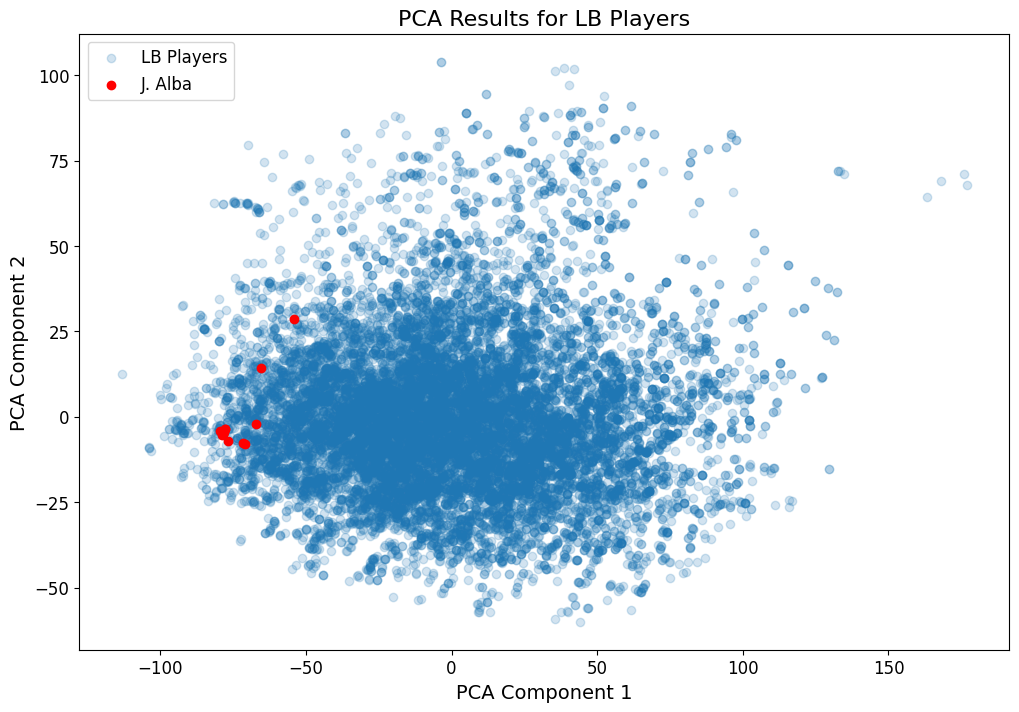

In [ ]:
# perform PCA on the statistics data
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
lb_player_stats_pca = pca.fit_transform(lb_players_stats)

# Define the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 8))

# Set the title of the plot
ax.set_title('PCA Results for LB Players', fontsize=16)

# Set the x and y axis labels
ax.set_xlabel('PCA Component 1', fontsize=14)
ax.set_ylabel('PCA Component 2', fontsize=14)

# Set the font size of the tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Plot the PCA results for all LB players
ax.scatter(lb_player_stats_pca[:, 0], lb_player_stats_pca[:, 1], label='LB Players',alpha=0.2)

# Plot the point for J. Alba in a different color
j_alba_row = lb_players[lb_players['Name'] == 'J. Alba']
j_alba_stats_pca = pca.transform(j_alba_row[lb_players_stats.columns])
ax.scatter(j_alba_stats_pca[:, 0], j_alba_stats_pca[:, 1], color='red', label='J. Alba')

# Add a legend to the plot
ax.legend(loc='upper left', fontsize=12)

# Show the plot
plt.show()


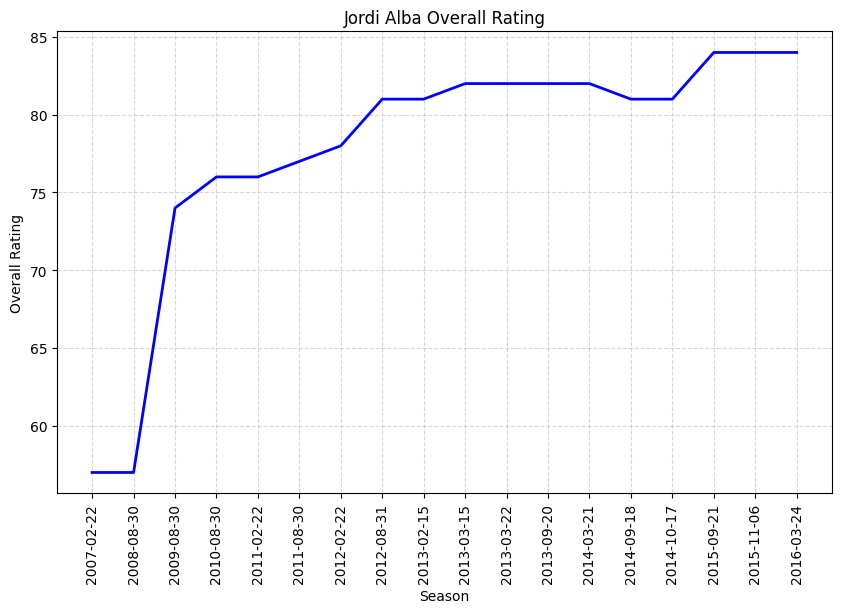

In [ ]:
j_alba = df_total[df_total['Name'] == 'J. Alba'].iloc[:, 1:41]

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(formatted_timestamps, j_alba['overall_rating'], color='blue', linewidth=2)

# Set x-axis labels to horizontal
plt.xticks(rotation=90)

# Add labels and title
ax.set_xlabel('Season')
ax.set_ylabel('Overall Rating')
ax.set_title('Jordi Alba Overall Rating')

# Add grid
ax.grid(True, linestyle='--', alpha=0.5)
plt.gca().invert_xaxis()

# Show plot
plt.show()

In [ ]:
# select only the rows where position is 'LB'
st_players = df_total[df_total['ST'] == 1]
st_players_stats = st_players.iloc[:, 1:41]

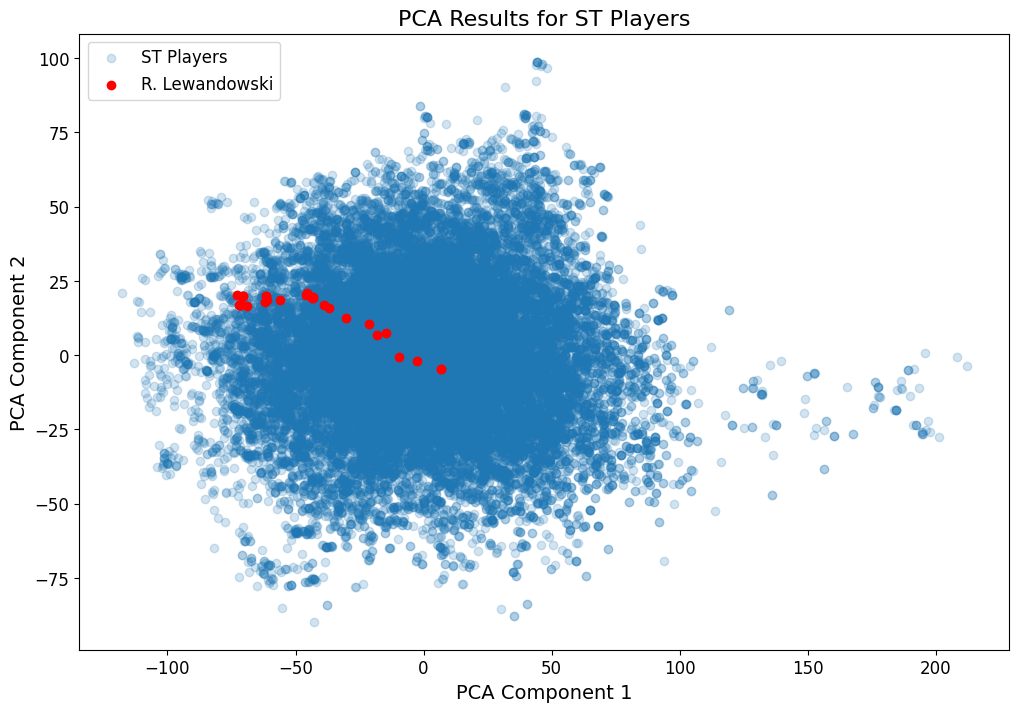

In [ ]:
pca = PCA(n_components=2)
st_player_stats_pca = pca.fit_transform(st_players_stats)

# Define the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 8))

# Set the title of the plot
ax.set_title('PCA Results for ST Players', fontsize=16)

# Set the x and y axis labels
ax.set_xlabel('PCA Component 1', fontsize=14)
ax.set_ylabel('PCA Component 2', fontsize=14)

# Set the font size of the tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Plot the PCA results for all LB players
ax.scatter(st_player_stats_pca[:, 0], st_player_stats_pca[:, 1], label='ST Players',alpha=0.2)

# Plot the point for J. Alba in a different color
rlew_row = st_players[st_players['Name'] == 'R. Lewandowski']
rlew_stats_pca = pca.transform(rlew_row[st_players_stats.columns])
ax.scatter(rlew_stats_pca[:, 0], rlew_stats_pca[:, 1], color='red', label='R. Lewandowski')

# Add a legend to the plot
ax.legend(loc='upper left', fontsize=12)

# Show the plot
plt.show()

['2016-01-28', '2016-01-07', '2015-10-23', '2015-10-16', '2015-09-21', '2015-05-08', '2015-03-06', '2015-01-09', '2014-10-10', '2014-09-18', '2014-05-16', '2014-05-09', '2014-04-25', '2014-04-18', '2014-03-28', '2014-01-24', '2014-01-17', '2013-09-20', '2013-05-17', '2013-05-10', '2013-05-03', '2013-02-22', '2013-02-15', '2012-08-31', '2012-02-22', '2011-08-30', '2011-02-22', '2010-08-30', '2009-08-30', '2009-02-22', '2008-08-30', '2007-02-22']


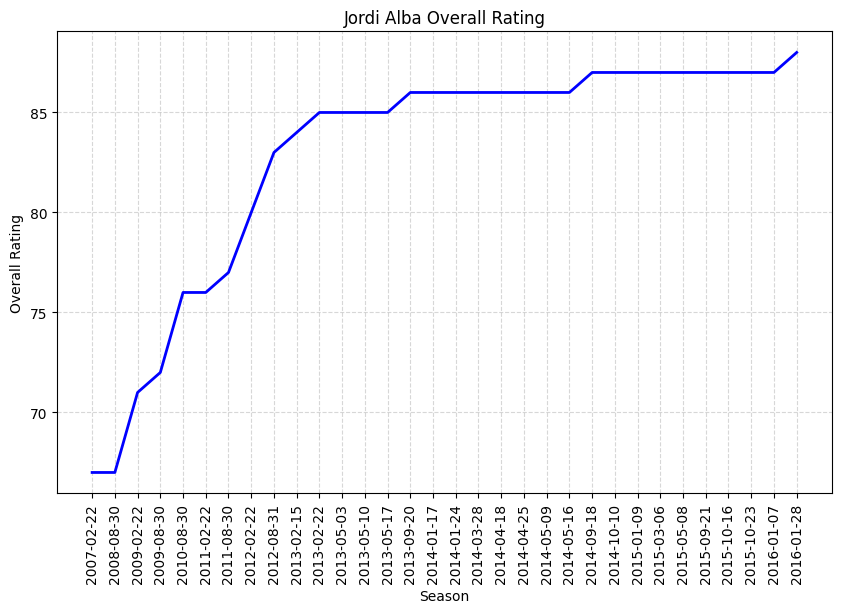

In [ ]:
r_lew = df_total[df_total['Name'] == 'R. Lewandowski'].iloc[:, 1:41]
sesons = df_merged[df_merged['player_name']=='Robert Lewandowski']['date']

# Loop through each timestamp and convert it to a datetime object, then format it without the hour part
formatted_timestamps = []
for ts in sesons.values:
    dt = datetime.strptime(ts, '%Y-%m-%d %H:%M:%S')
    formatted_timestamps.append(dt.strftime('%Y-%m-%d'))

print(formatted_timestamps)

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(formatted_timestamps, r_lew['overall_rating'], color='blue', linewidth=2)

# Set x-axis labels to horizontal
plt.xticks(rotation=90)

# Add labels and title
ax.set_xlabel('Season')
ax.set_ylabel('Overall Rating')
ax.set_title('Jordi Alba Overall Rating')

# Add grid
ax.grid(True, linestyle='--', alpha=0.5)
plt.gca().invert_xaxis()

# Show plot
plt.show()

['2016-01-28', '2015-09-21', '2015-04-17', '2014-09-18', '2014-05-02', '2014-02-28', '2014-01-10', '2013-11-29', '2013-09-27', '2013-09-20', '2013-06-07', '2013-05-10', '2013-03-15', '2013-02-15', '2012-08-31', '2012-02-22', '2011-08-30', '2011-02-22', '2010-08-30', '2010-02-22', '2009-08-30', '2008-08-30', '2007-08-30', '2007-02-22']


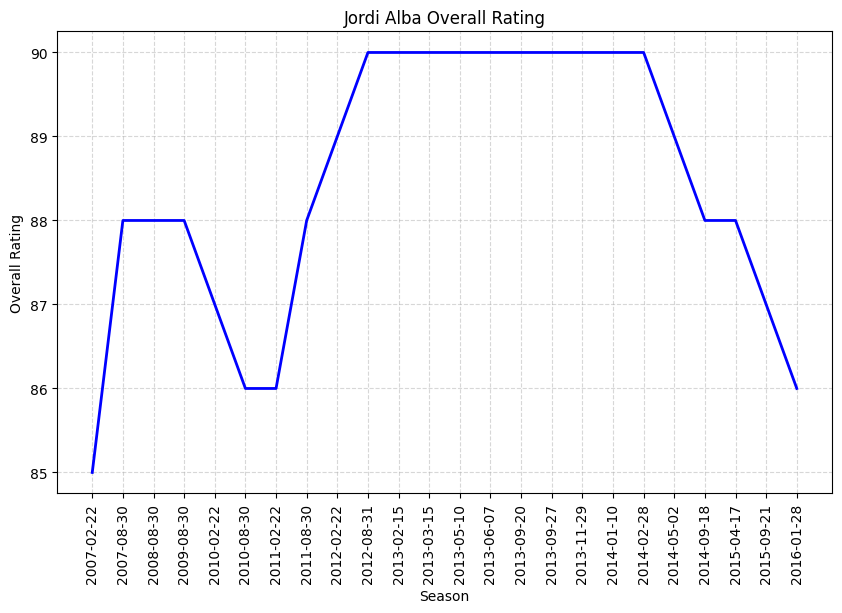

In [ ]:
r_lew = df_total[df_total['Name'] == 'F. Ribery'].iloc[:, 1:41]
sesons = df_merged[df_merged['player_name']=='Franck Ribery']['date']

# Loop through each timestamp and convert it to a datetime object, then format it without the hour part
formatted_timestamps = []
for ts in sesons.values:
    dt = datetime.strptime(ts, '%Y-%m-%d %H:%M:%S')
    formatted_timestamps.append(dt.strftime('%Y-%m-%d'))

print(formatted_timestamps)

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(formatted_timestamps, r_lew['overall_rating'], color='blue', linewidth=2)

# Set x-axis labels to horizontal
plt.xticks(rotation=90)

# Add labels and title
ax.set_xlabel('Season')
ax.set_ylabel('Overall Rating')
ax.set_title('Jordi Alba Overall Rating')

# Add grid
ax.grid(True, linestyle='--', alpha=0.5)
plt.gca().invert_xaxis()

# Show plot
plt.show()

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca_features = pca.fit(X_scaled)
var_exp = pca.explained_variance_ratio_

In [ ]:
suma = 0
varianza = []
suma_varianzas = []
n_componentes = []

for i, val in enumerate(pca.explained_variance_ratio_):
    suma += val
    varianza.append(val)
    suma_varianzas.append(suma)
    n_componentes.append("PC"+str(i+1))

df_var = pd.DataFrame({'n_componentes':n_componentes,'varianza':varianza,'suma_varianzas':suma_varianzas})
df_var = df_var.set_index('n_componentes')

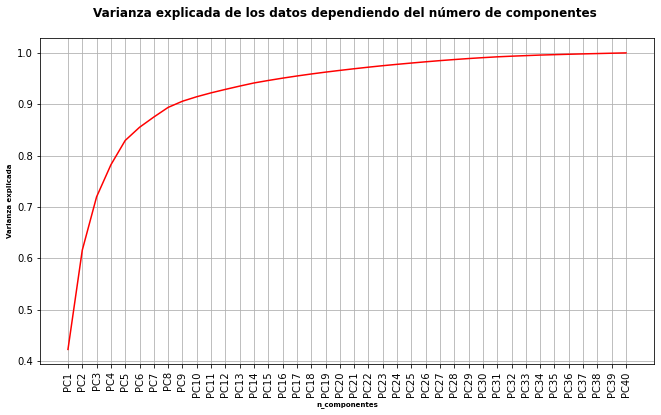

In [ ]:
df_var_plt = df_var[0:50]

import matplotlib.pyplot as plt
#Creamos el Plot de la varianza de la PCA
fig,ax = plt.subplots()
fig.set_size_inches(11,6)
ax.plot(df_var_plt.index,df_var_plt['suma_varianzas'], color = 'red')


ax.set_xlabel('n_componentes', fontsize = 7, fontweight ='bold')
plt.xticks(rotation = 90)
ax.set_ylabel('Varianza explicada', fontsize = 7, fontweight ='bold')

ax.set_title("Varianza explicada de los datos dependiendo del número de componentes \n",
             fontweight ='bold', fontsize = 12)
plt.grid()
plt.plot();

**Elbow Curve - 6 Components**

In [ ]:
pca_model = PCA(n_components=8)
X_red = pca_model.fit_transform(X)

In [ ]:
pca_model = PCA(n_components=8)
X_red = pca_model.fit_transform(X)

dataframe_plt = pd.DataFrame()
dataframe_plt['PCA_1'] = X_red[:,0]
dataframe_plt['PCA_2'] = X_red[:,1]
dataframe_plt['Pos'] = y_pos.values
dataframe_plt.head()

PCA_1      PCA_2  Pos
0 -34.724512 -26.785505   LB
1   7.790939 -71.815623   LB
2 -68.220616  50.964198  RCM
3 -52.546050  70.519464   RM
4 -48.110077 -16.659415   LB

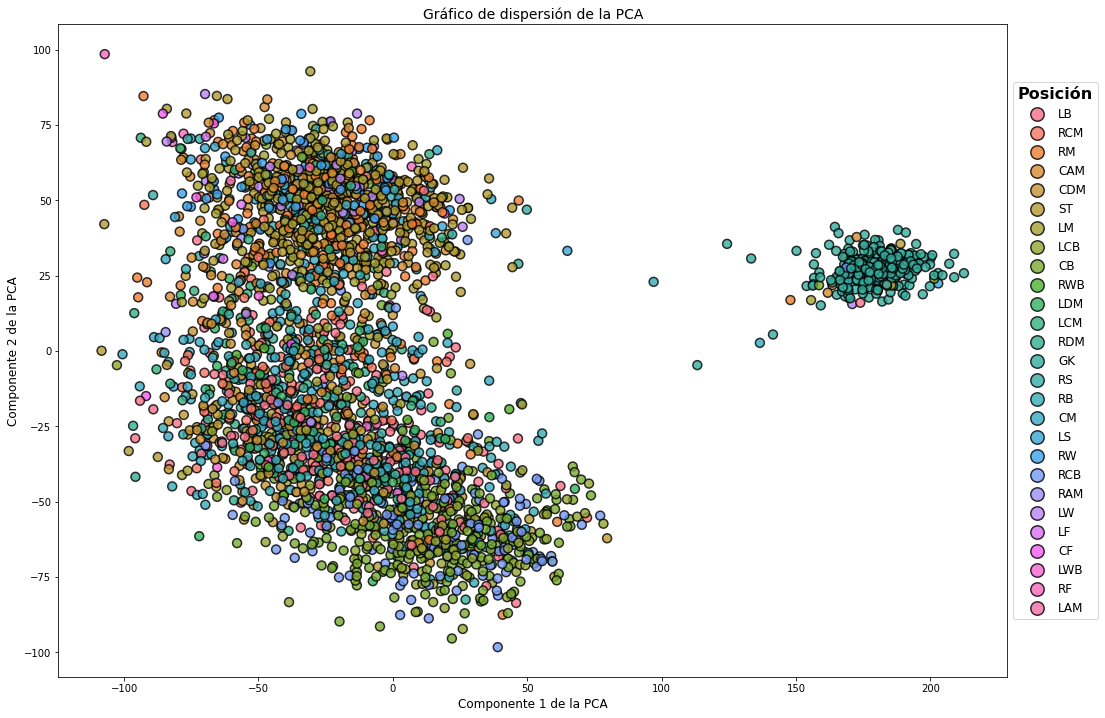

In [ ]:
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

# Generar una paleta de colores basada en las posiciones únicas en el dataframe
palette = sns.color_palette('husl', len(dataframe_plt['Pos'].unique()))

# Asignar un color a cada posición en función de la paleta de colores
colors = [palette[i] for i in range(len(dataframe_plt['Pos'].unique()))]
color_dict = dict(zip(dataframe_plt['Pos'].unique(), colors))
color_labels = [color_dict[x] for x in dataframe_plt['Pos']]

# Crear el scatterplot de las dos componentes de la PCA y asignar el color correspondiente a cada posición
plt.figure(figsize=(17,12)) # ajustar tamaño de la figura
plt.scatter(x=dataframe_plt['PCA_1'], y=dataframe_plt['PCA_2'],
            color=dataframe_plt['Pos'].map(color_dict), alpha=0.8, s=80, edgecolors='black', linewidths=1.5)

plt.xlabel('Componente 1 de la PCA', fontsize=12) # agregar etiqueta y tamaño de fuente al eje x
plt.ylabel('Componente 2 de la PCA', fontsize=12)
plt.title('Gráfico de dispersión de la PCA', fontsize=14) # agregar título y tamaño de fuente al gráfico
plt.xticks(fontsize=10) # ajustar tamaño de fuente de los ticks en el eje x
plt.yticks(fontsize=10) # ajustar tamaño de fuente de los ticks en el eje y

# Crear la leyenda
labels = list(color_dict.keys())
handles = [plt.scatter([], [], color=color_dict[label], alpha=0.8, s=80, edgecolors='black', linewidths=1.5) for label in labels]
legend = plt.legend(handles, labels, title='Posición', fontsize=12, markerscale=1.5,
                    bbox_to_anchor=(1.0, 0.5), loc='center left')
legend.set_title('Posición', prop={'size': 16, 'weight': 'bold'})

plt.show()

In [ ]:
dictionray_pos = {'GK': 'Goalkeeper', 'RB': 'Defender','RCB':'Defender',
                   'LB': 'Defender','LCB':'Defender','RWB': 'Defender',
                   'LWB': 'Defender','CB': 'Defender', 'LAM':'Midfielders',
                   'CDM': 'Midfielders','CM': 'Midfielders', 'RDM':'Midfielders',
                   'LDM':'Midfielders','LCM':'Midfielders','CAM': 'Midfielders',
                   'RM': 'Midfielders','LM': 'Midfielders','RCM':'Midfielders',
                   'RW': 'Forwards','RAM':'Forwards','LS':'Forwards',
                   'RS':'Forwards','LW': 'Forwards','RF': 'Forwards',
                   'LF': 'Forwards','CF': 'Forwards','ST': 'Forwards'}



dataframe_plt['Pos'] = dataframe_plt['Pos'].replace(dictionray_pos)

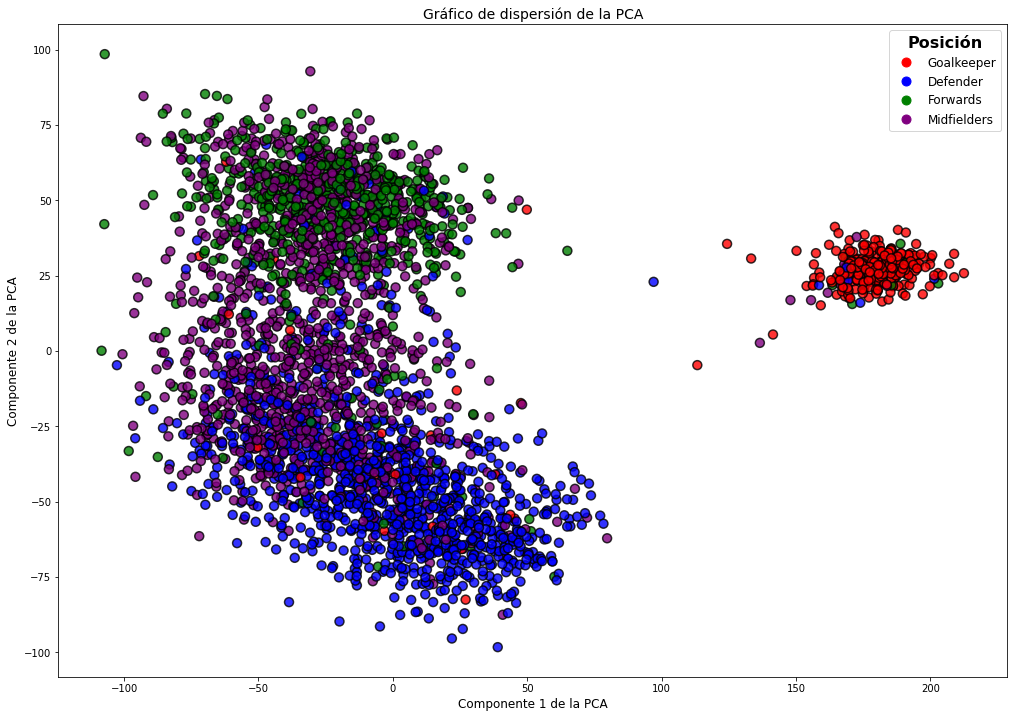

In [ ]:
#fig,ax = plt.subplots()
plt.figure(figsize=(17,12)) # ajustar tamaño de la figura

dataframe_plt.dropna(inplace=True)

# Create a list of colors for each position
colors = {'Goalkeeper': 'red', 'Defender': 'blue', 'Forwards': 'green', 'Midfielders': 'purple'}
dataframe_plt['Color'] = dataframe_plt['Pos'].apply(lambda x: colors[x])

df_plt = dataframe_plt #[dataframe_plt['Pos']=='Midfielders']
# Create the scatter plot
plt.scatter(df_plt['PCA_1'], df_plt['PCA_2'],
            c=df_plt['Color'], alpha=0.8, s=80,
            edgecolors='black', linewidths=1.5)


# Add axis labels and a title
plt.xlabel('Componente 1 de la PCA', fontsize=12) # agregar etiqueta y tamaño de fuente al eje x
plt.ylabel('Componente 2 de la PCA', fontsize=12)
plt.title('Gráfico de dispersión de la PCA', fontsize=14) # agregar título y tamaño de fuente al gráfico
plt.xticks(fontsize=10) # ajustar tamaño de fuente de los ticks en el eje x
plt.yticks(fontsize=10) # ajustar tamaño de fuente de los ticks en el eje y

legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=pos,
                              linestyle='') for pos, color in colors.items()]
legend = plt.legend(handles=legend_elements, title='Posición', fontsize=12, markerscale=1.5,
                    loc='upper right')
legend.set_title('Posición', prop={'size': 16, 'weight': 'bold'})

# Show the plot
plt.show()

# New DataFrame Position:

Modifed to have less positions:

In [ ]:
dict_simpl_pos = {'GK': 'GK', # Portero

                  'RCB': 'DEF','CB':'DEF','LCB':'DEF', # Centrales

                   'LB': 'LI','LWB':'LI', # Lat Izquierda

                   'RB':'LD','RWB':'LD', # Lat Derecha

                   'RDM': 'MCD','CDM':'MCD', 'LDM':'MCD', # Med Def

                   'CM': 'MC','LCM':'MC', 'RCM':'MC', # MedC

                   'RAM':'MCO','CAM':'MCO','LAM':'MCO', # Med Of

                   'LM':'MD','RM':'MI', # MI and MD

                   'LF':'EI', 'LW':'EI', #EI
                   'RF':'ED', 'RW':'ED', #ED

                   'ST':'DC', 'CF':'DC','LS':'DC','RS':'DC', #DC

                  }

In [ ]:
positions_dict = {
    "GK": "Goalkeeper",
    "RB": "Fullbacks",
    "LB": "Fullbacks",
    "RWB": "Fullbacks",
    "LWB": "Fullbacks",
    "RCB": "Centerbacks",
    "LCB": "Centerbacks",
    "CB": "Centerbacks",
    "RDM": "Defensive Midfielders",
    "CDM": "Defensive Midfielders",
    "MDL": "Defensive Midfielders",
    "CM": "Central Midfielders",
    "LDM":"Central Midfielders",
    "LCM": "Central Midfielders",
    "RCM": "Central Midfielders",
    "CAM": "Attacking Midfielders",
    "RAM": "Attacking Midfielders",
    "LAM": "Attacking Midfielders",
    "RM": "Right-sided Midfielders",
    "RCM": "Right-sided Midfielders",
    "RW": "Right-sided Midfielders",
    "RAM": "Right-sided Midfielders",
    "RF": "Right-sided Midfielders",
    "LM": "Left-sided Midfielders",
    "LCM": "Left-sided Midfielders",
    "LW": "Left-sided Midfielders",
    "LAM": "Left-sided Midfielders",
    "LF": "Left-sided Midfielders",
    "RW": "Strikers",
    "LW": "Strikers",
    "RF": "Strikers",
    "LF": "Strikers",
    "LS": "Strikers",
    "RS": "Strikers",
    "CF": "Strikers",
    "ST": "Strikers"
}


In [ ]:
new_data = df_positions_without_na.copy()
new_data['Position'] = new_data['Position'].replace(positions_dict)
new_data.head(2)

Name   Position  height  weight  overall_rating  potential  \
1  A. Cresswell  Fullbacks  170.18   146.0       66.969697  74.484848   
4     A. Hughes  Fullbacks  182.88   154.0       73.240000  74.680000   

   preferred_foot  attacking_work_rate  defensive_work_rate   crossing  ...  \
1        0.060606             1.212121                  1.0  70.787879  ...   
4        1.000000             1.000000                  1.0  45.080000  ...   

      vision  penalties    marking  standing_tackle  sliding_tackle  \
1  57.454545  53.121212  69.393939        68.787879       71.515152   
4  46.480000  52.960000  77.600000        76.040000       74.600000   

   gk_diving  gk_handling  gk_kicking  gk_positioning  gk_reflexes  
1  12.181818     8.666667   14.242424       10.363636    12.909091  
4   8.280000     8.320000   24.920000       12.840000    11.920000  

[2 rows x 42 columns]

### Outliers:

In [ ]:
# Define a function to calculate Z-scores and identify outliers
def find_outliers(data):
    numeric_cols = data.select_dtypes(include='number').columns
    z_scores = np.abs((data[numeric_cols] - data[numeric_cols].mean()) / data[numeric_cols].std())
    threshold = 2.75
    outliers = data[(z_scores > threshold).any(axis=1)]
    return outliers


Goalkeeper: 61 players eliminated, 253 players remaining
Fullbacks: 107 players eliminated, 409 players remaining
Centerbacks: 78 players eliminated, 529 players remaining
Defensive Midfielders: 63 players eliminated, 156 players remaining
Central Midfielders: 38 players eliminated, 220 players remaining
Attacking Midfielders: 18 players eliminated, 145 players remaining
Right-sided Midfielders: 34 players eliminated, 253 players remaining
Left-sided Midfielders: 43 players eliminated, 278 players remaining
Wingers: 0 players eliminated, 0 players remaining
Strikers: 83 players eliminated, 545 players remaining




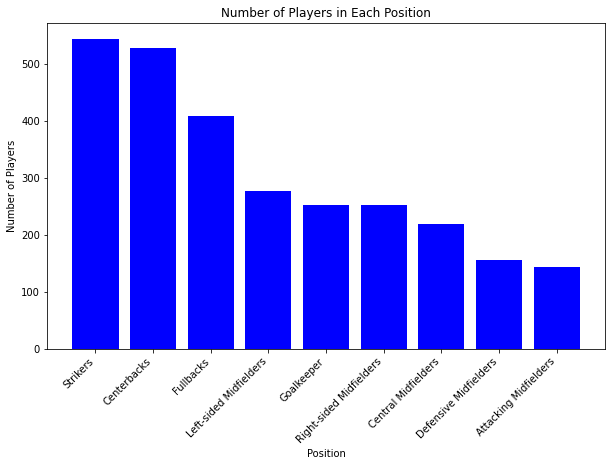

In [ ]:
# Define a list of all possible positions
positions = ['Goalkeeper', 'Fullbacks','Centerbacks','Defensive Midfielders',
             'Central Midfielders','Attacking Midfielders','Right-sided Midfielders',
             'Left-sided Midfielders','Wingers','Strikers']

# Define a dictionary to store the outliers for each position
outliers_dict = {}

# Create a new dataframe to store the cleaned data
cleaned_data = pd.DataFrame(columns=new_data.columns)

# Loop through each position and detect outliers
for pos in positions:
    pos_df = new_data[new_data['Position'] == pos]
    outliers = find_outliers(pos_df)
    if not outliers.empty:
        outliers_dict[pos] = outliers
        pos_df = pos_df.drop(outliers.index)
    cleaned_data = pd.concat([cleaned_data, pos_df])
    num_eliminated = len(outliers)
    num_remaining = len(pos_df)
    #per_eliminated = (num_eliminated / (num_eliminated+num_remaining))*100
    print(f'{pos}: {num_eliminated} players eliminated, {num_remaining} players remaining')

# Drop any remaining duplicates
cleaned_data = cleaned_data.drop_duplicates()

print('\n')
# Create a decorated bar chart showing the number of players in each position
player_counts = cleaned_data['Position'].value_counts()
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(player_counts.index, player_counts.values, color='blue')
ax.set_title('Number of Players in Each Position')
ax.set_xlabel('Position')
ax.set_ylabel('Number of Players')
plt.xticks(rotation=45, ha='right')
plt.show()

# Ap No supervisado:

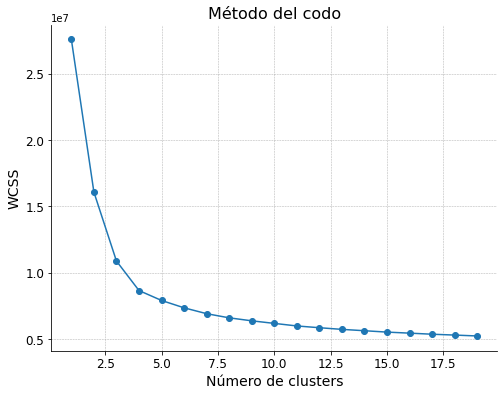

In [ ]:
# Calcular WCSS para diferentes números de clusters
from sklearn.cluster import KMeans
X = df_positions_without_na.drop(['Name','Position'],axis=1)
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Graficar el método del codo
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(1, 20), wcss, marker='o')
ax.set_title('Método del codo', fontsize=16)
ax.set_xlabel('Número de clusters', fontsize=14)
ax.set_ylabel('WCSS', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# Train/Test Division:

In [ ]:
from sklearn.model_selection import train_test_split
# Split data into training and testing sets

train, test = train_test_split(cleaned_data, test_size=0.2, random_state=42)
print(len(train))
print(len(test))

2230
558


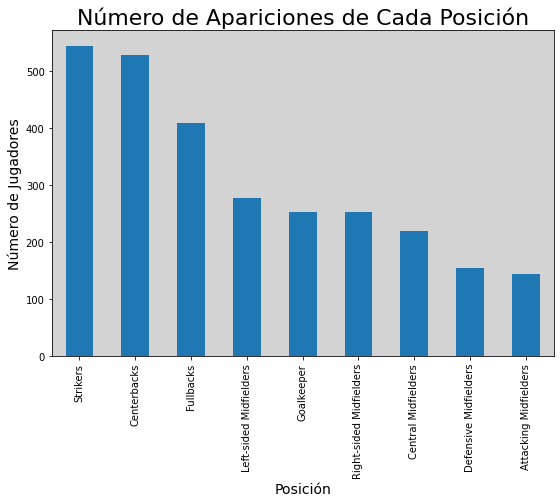

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(9,6)
# contar el numero de apariciones de cada valor unico en la columna 'posicion'
counts = cleaned_data['Position'].value_counts()

# crear grafico de barras a partir de los valores resultantes
counts.plot(kind='bar', ax=ax)

# agregar titulos y etiquetas de ejes
ax.set_title('Número de Apariciones de Cada Posición', fontsize=22)
ax.set_xlabel('Posición', fontsize=14)
ax.set_ylabel('Número de Jugadores',fontsize=14)
ax.set_facecolor('lightgrey')
plt.show()

In [ ]:
df_allpos = df_positions_without_na[~df_positions_without_na['Position'].isin(['CF', 'LF', 'RF',
                                                                               'RAM','LAM'])]

In [ ]:
from sklearn.model_selection import train_test_split
# Split data into training and testing sets

train, test = train_test_split(cleaned_data, test_size=0.2, random_state=42)
print(len(train))
print(len(test))

2230
558


# OverSample Data:

In [ ]:
from imblearn.over_sampling import RandomOverSampler
df_to_ovsp = train.drop('Name',axis=1)

# Obtener el número de Position por posición
count_pos = df_to_ovsp['Position'].value_counts()

# Obtener las posiciones con menos jugadores
minority_pos = count_pos[count_pos < count_pos.max()].index.tolist()

# Definir la estrategia de sobremuestreo (oversampling)
oversample = RandomOverSampler(sampling_strategy={pos: int(count_pos.max()) for pos in minority_pos})

# Separar los datos en
# Separar los datos en características (X) y etiquetas (y)
X = df_to_ovsp.drop('Position', axis=1)
y = df_to_ovsp['Position']

# Aplicar el sobremuestreo a los datos
X_resampled, y_resampled = oversample.fit_resample(X, y)

# Combinar las características (X_resampled) y etiquetas (y_resampled) en un nuevo dataframe
df_resampled = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['Position'])], axis=1)


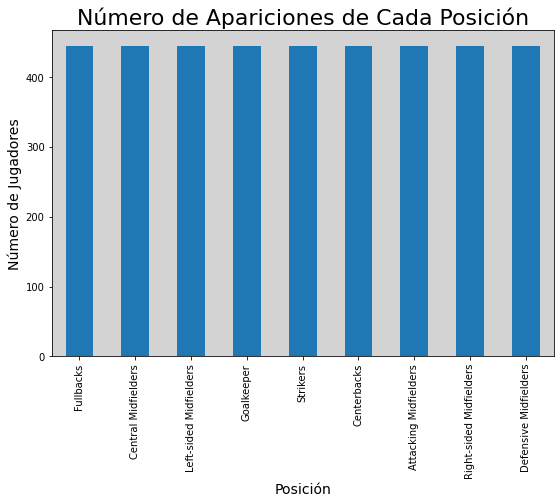

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(9,6)
# contar el numero de apariciones de cada valor unico en la columna 'posicion'
counts = df_resampled['Position'].value_counts()

# crear grafico de barras a partir de los valores resultantes
counts.plot(kind='bar', ax=ax)

# agregar titulos y etiquetas de ejes
ax.set_title('Número de Apariciones de Cada Posición', fontsize=22)
ax.set_xlabel('Posición', fontsize=14)
ax.set_ylabel('Número de Jugadores',fontsize=14)
ax.set_facecolor('lightgrey')
plt.show()

#Positions Neural Network:

In [ ]:
X_train = train.drop(['Name','Position'],axis=1)
y_train = pd.get_dummies(train['Position'])
X_test = test.drop(['Name','Position'],axis=1)
y_test = pd.get_dummies(test['Position'])

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#y_train = train['Position']
#y_test = test['Position']

#from sklearn.preprocessing import LabelEncoder
# Encode the labels
#le = LabelEncoder()
#y_train = le.fit_transform(y_train)
#y_test = le.transform(y_test)

from keras import regularizers
from keras.layers import Dropout, BatchNormalization

# Define the model architecture with modifications
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(40,), kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

# Compile the model with modifications
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with modifications
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras import regularizers
from keras.layers import Dropout, BatchNormalization
from keras import regularizers


# Definir la métrica
#metric = tf.metrics.SparseCategoricalF1Score(num_classes=10)

# Definir el modelo
model = tf.keras.Sequential([
    tf.keras.layers.Dense(84, activation='elu', input_dim = X_train_final.shape[1], kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),
    tf.keras.layers.Dense(63, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),
    tf.keras.layers.Dense(42, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),
    tf.keras.layers.Dense(22, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adamax(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test))


ModuleNotFoundError: ignored

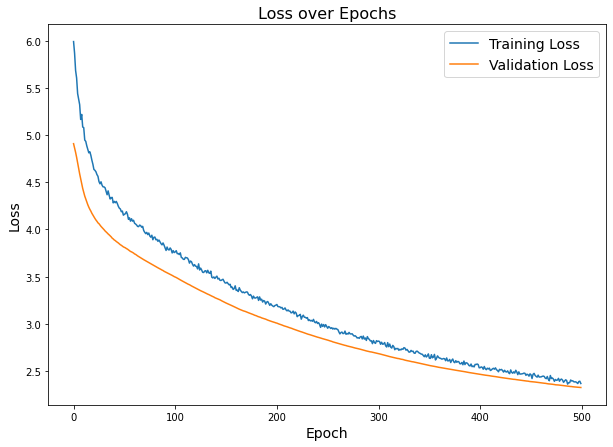

In [ ]:
# plot loss
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

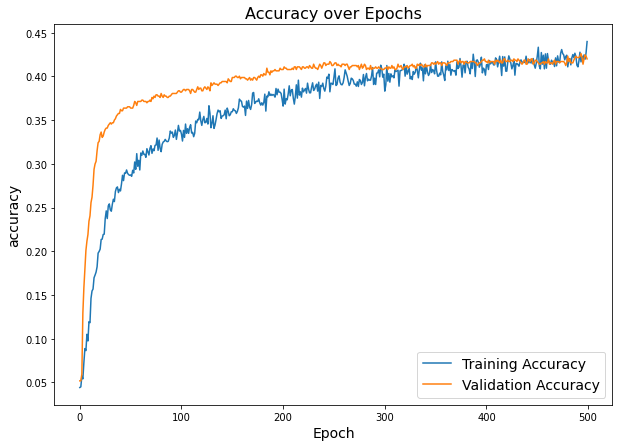

In [ ]:
# plot loss
plt.figure(figsize=(10, 7))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [ ]:
# Predecir las clases para los datos de prueba
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(np.array(y_pred), axis=1)
y_test_labels = np.argmax(np.array(y_test), axis=1)

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
# Calcular la exactitud (accuracy)
accuracy = accuracy_score(y_test_labels, y_pred_labels)
# Calcular el F1 score
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
# Calcular el recall
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
# Calcular la precisión (precision)
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')



21/21 [==============================] - 0s 4ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('Accuracy:',accuracy)
print('F1 Score:',f1)
print('Precision:',recall)
print('Recall:',precision)

Accuracy: 0.4200913242009132
F1 Score: 0.347154395857227
Precision: 0.4200913242009132
Recall: 0.3172110688871153


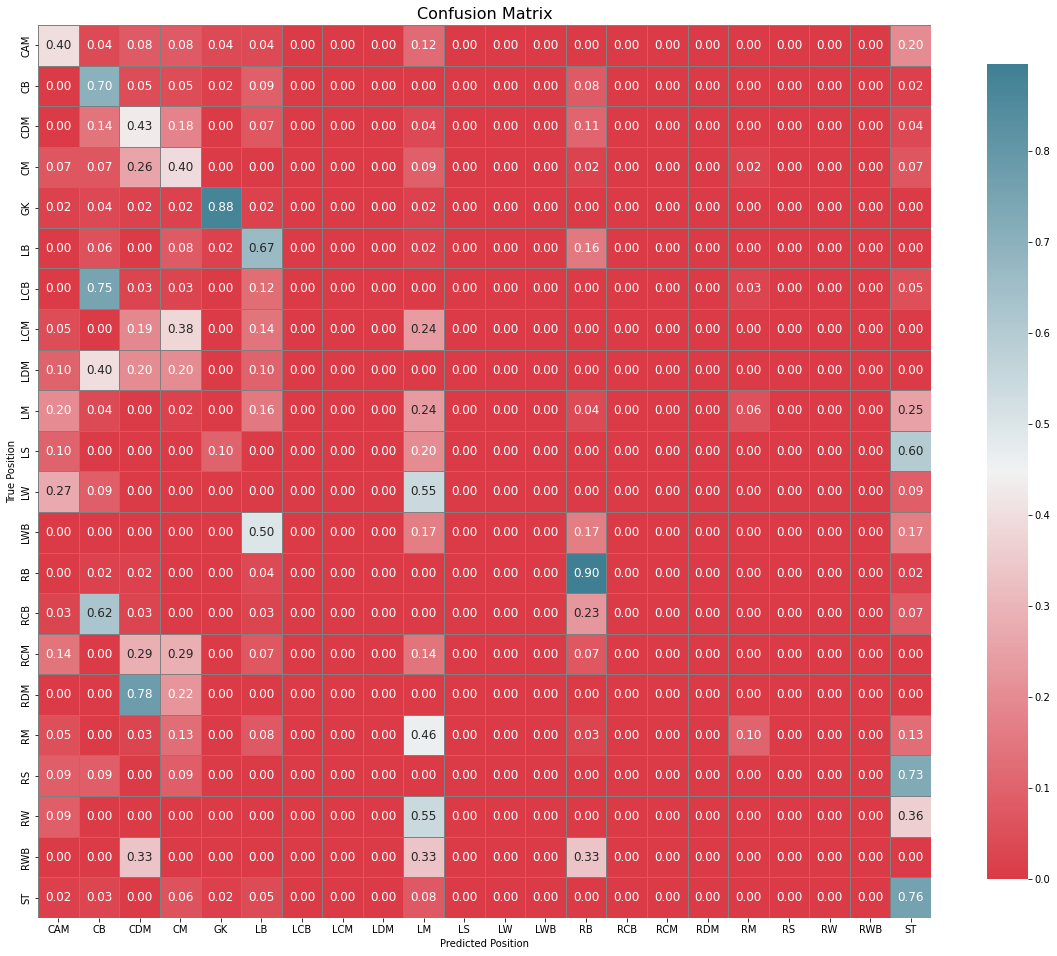

In [ ]:
from sklearn.metrics import confusion_matrix
# Generate confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
#cm = confusion_matrix(y_test, y_pred_labels)
# convert to percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# define color scheme
cmap = sns.diverging_palette(10, 220, as_cmap=True)
norm = plt.Normalize(cm_percent.min(), cm_percent.max())

fig,ax = plt.subplots()
fig.set_size_inches(20,20)
# create heatmap with custom color scheme
sns.heatmap(cm_percent, cmap=cmap, annot=True, fmt='.2f', square=True,
            xticklabels=list(y_test.columns),
            yticklabels=list(y_test.columns),
            annot_kws={'fontsize':12}, cbar_kws={"shrink": .75},
            vmin=0, vmax=1, center=0.5, norm=norm,
            linewidths=.5, linecolor='gray')
plt.xlabel('Predicted Position')
plt.ylabel('True Position')
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# Transfer Learning:

In [ ]:
X_train = train.drop(['Name','Position'],axis=1)
#y_train = pd.get_dummies(train['Position'])
X_test = test.drop(['Name','Position'],axis=1)
#y_test = pd.get_dummies(test['Position'])

y_train = train['Position']
y_test = test['Position']

#from sklearn.preprocessing import LabelEncoder
# Encode the labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
# Load the pre-trained TabNet model
from pytorch_tabnet.tab_model import TabNetClassifier
tabnet_model = TabNetClassifier()

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Train the model on the player statistics data
tabnet_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], patience=10, max_epochs=750)

# Evaluate the model on a held-out 20% of the data
from sklearn.metrics import accuracy_score
y_pred = tabnet_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Print the model's accuracy on the held-out data
print(f'Test accuracy: {accuracy}')


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4.10021 | val_0_accuracy: 0.03349 |  0:00:00s
epoch 1  | loss: 3.59981 | val_0_accuracy: 0.04262 |  0:00:00s
epoch 2  | loss: 3.34721 | val_0_accuracy: 0.08219 |  0:00:00s
epoch 3  | loss: 3.1323  | val_0_accuracy: 0.07915 |  0:00:01s
epoch 4  | loss: 3.00449 | val_0_accuracy: 0.07306 |  0:00:01s
epoch 5  | loss: 2.89858 | val_0_accuracy: 0.0898  |  0:00:01s
epoch 6  | loss: 2.85751 | val_0_accuracy: 0.07915 |  0:00:02s
epoch 7  | loss: 2.80819 | val_0_accuracy: 0.09741 |  0:00:02s
epoch 8  | loss: 2.73537 | val_0_accuracy: 0.08676 |  0:00:02s
epoch 9  | loss: 2.68317 | val_0_accuracy: 0.07306 |  0:00:03s
epoch 10 | loss: 2.66622 | val_0_accuracy: 0.09437 |  0:00:03s
epoch 11 | loss: 2.68226 | val_0_accuracy: 0.11263 |  0:00:03s
epoch 12 | loss: 2.72387 | val_0_accuracy: 0.1446  |  0:00:04s
epoch 13 | loss: 2.67335 | val_0_accuracy: 0.1583  |  0:00:04s
epoch 14 | loss: 2.61581 | val_0_accuracy: 0.10198 |  0:00:04s
epoch 15 | loss: 2.57818 | val_0_accuracy: 0.12177 |  0

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Test accuracy: 0.1582952815829528


In [ ]:

model = models.Sequential()
model.add(layers.Flatten(input_shape=conv_base.output_shape[1:]))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(22, activation='softmax'))

# Compile the model and train it on the extracted features
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(features, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


# Feature Selection:

In [ ]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
X = df_allpos.drop(['Name','Position'], axis=1)
y = df_allpos['Position']

ModuleNotFoundError: ignored

In [ ]:
# initialize a random forest classifier
rfc = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# initialize the Boruta feature selection object
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2, random_state=42)

# fit the Boruta feature selector on the player data
boruta_selector.fit(X.values, y.values)

# extract the confirmed features
confirmed_features = X.columns[boruta_selector.support_]
# create a new dataframe with only the confirmed features
X_confirmed = X[confirmed_features]

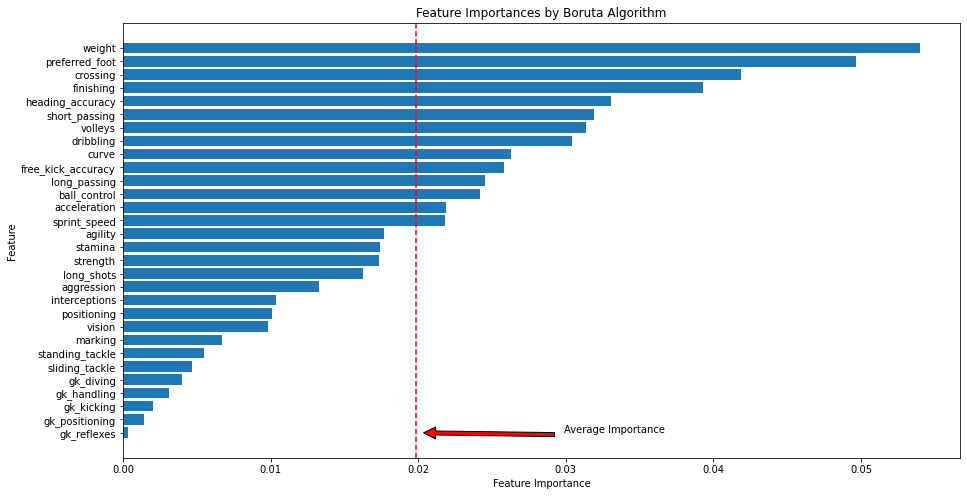

In [ ]:
# get the feature importances from the random forest classifier
importances = rfc.feature_importances_

# get the indices of the confirmed features
indices = [X.columns.get_loc(f) for f in confirmed_features]

# sort the importances and indices in descending order
importances, indices = zip(*sorted(zip(importances[indices], indices), reverse=True))

# create a horizontal bar chart of feature importances
fig, ax = plt.subplots(figsize=(15, 8))
ax.barh(range(len(indices)), importances, align='center')
ax.set_yticks(range(len(indices)))
ax.set_yticklabels(confirmed_features)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importances by Boruta Algorithm')

# add a vertical line to mark the average feature importance
ax.axvline(np.mean(importances), color='r', linestyle='--')
ax.annotate('Average Importance', xy=(np.mean(importances), len(confirmed_features) - 1), xytext=(np.mean(importances) + 0.01, len(confirmed_features) - 1),
            arrowprops=dict(facecolor='red', shrink=0.05))

plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_confirmed, y, test_size=0.2, random_state=42)

In [ ]:
#X_train = train.drop(['Position'],axis=1)
y_train = np.array(pd.get_dummies(y_train))
#X_test = test.drop(['Position'],axis=1)
y_test = np.array(pd.get_dummies(y_test))

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Definir la métrica
#metric = tf.metrics.SparseCategoricalF1Score(num_classes=10)

# Definir el modelo
model = tf.keras.Sequential([
    tf.keras.layers.Dense(84, activation='elu', input_shape=(30,), kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),
    tf.keras.layers.Dense(63, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),
    tf.keras.layers.Dense(42, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),
    tf.keras.layers.Dense(22, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adamax(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/500
83/83 [==============================] - 22s 13ms/step - loss: 5.6669 - accuracy: 0.0426 - val_loss: 4.7623 - val_accuracy: 0.0289
Epoch 2/500
83/83 [==============================] - 1s 8ms/step - loss: 5.5508 - accuracy: 0.0620 - val_loss: 4.7504 - val_accuracy: 0.0228
Epoch 3/500
83/83 [==============================] - 1s 7ms/step - loss: 5.4154 - accuracy: 0.0731 - val_loss: 4.7192 - val_accuracy: 0.0381
Epoch 4/500
83/83 [==============================] - 1s 7ms/step - loss: 5.3687 - accuracy: 0.0715 - val_loss: 4.6584 - val_accuracy: 0.1065
Epoch 5/500
83/83 [==============================] - 0s 6ms/step - loss: 5.2733 - accuracy: 0.0708 - val_loss: 4.5841 - val_accuracy: 0.1461
Epoch 6/500
83/83 [==============================] - 0s 5ms/step - loss: 5.1975 - accuracy: 0.0814 - val_loss: 4.5158 - val_accuracy: 0.1705
Epoch 7/500
83/83 [==============================] - 0s 5ms/step - loss: 5.1101 - accuracy: 0.0898 - val_loss: 4.4571 - val_accuracy: 0.1826
Epoch 8/500

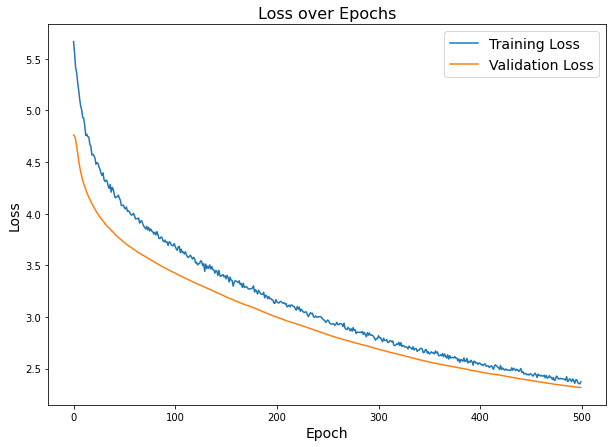

In [ ]:
# plot loss
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

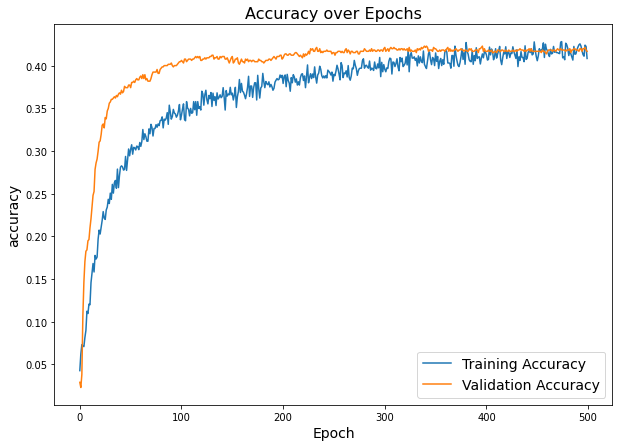

In [ ]:
# plot loss
plt.figure(figsize=(10, 7))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [ ]:
# Predecir las clases para los datos de prueba
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(np.array(y_pred), axis=1)
y_test_labels = np.argmax(np.array(y_test), axis=1)

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
# Calcular la exactitud (accuracy)
accuracy = accuracy_score(y_test_labels, y_pred_labels)
# Calcular el F1 score
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
# Calcular el recall
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
# Calcular la precisión (precision)
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')

print('Accuracy:',accuracy)
print('F1 Score:',f1)
print('Precision:',recall)
print('Recall:',precision)

21/21 [==============================] - 0s 4ms/step
Accuracy: 0.4170471841704718
F1 Score: 0.3398074966859205
Precision: 0.4170471841704718
Recall: 0.29255265738296304


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


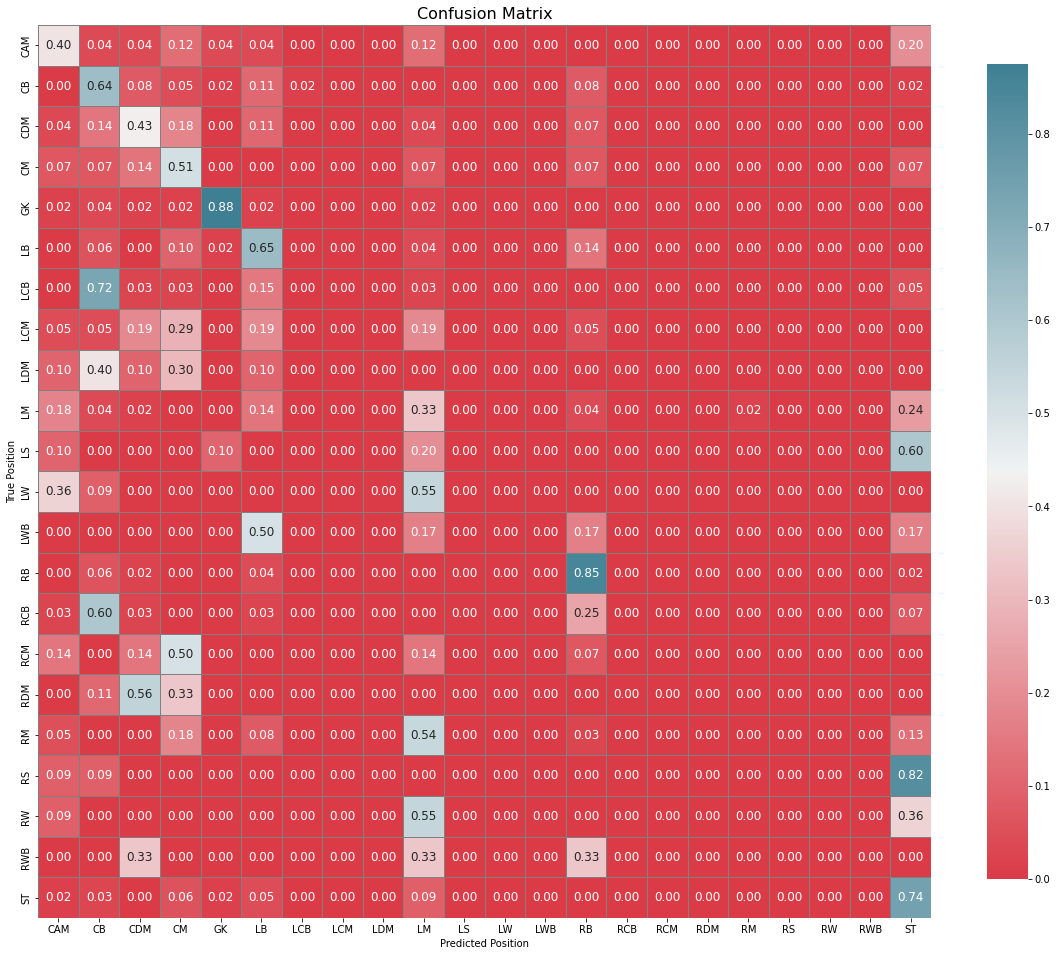

In [ ]:
from sklearn.metrics import confusion_matrix
# Generate confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
#cm = confusion_matrix(y_test, y_pred_labels)
# convert to percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# define color scheme
cmap = sns.diverging_palette(10, 220, as_cmap=True)
norm = plt.Normalize(cm_percent.min(), cm_percent.max())

fig,ax = plt.subplots()
fig.set_size_inches(20,20)
# create heatmap with custom color scheme
sns.heatmap(cm_percent, cmap=cmap, annot=True, fmt='.2f', square=True,
            xticklabels=list(pd.get_dummies(y).columns),
            yticklabels=list(pd.get_dummies(y).columns),
            annot_kws={'fontsize':12}, cbar_kws={"shrink": .75},
            vmin=0, vmax=1, center=0.5, norm=norm,
            linewidths=.5, linecolor='gray')
plt.xlabel('Predicted Position')
plt.ylabel('True Position')
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# Clustering:

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Create a subset of the dataframe with all positions
all_positions_df = new_data.drop(['Name','Position'], axis=1)

# Standardize the data
scaler = StandardScaler()
all_positions_df_std = scaler.fit_transform(all_positions_df)

In [ ]:
# Perform K-Means clustering with 12 clusters (one for each position)
kmeans = KMeans(n_clusters=11, random_state=0)
kmeans.fit(all_positions_df_std)

# Get the cluster assignments for each player
cluster_assignments = kmeans.predict(all_positions_df_std)

# Add the cluster assignments as a new column to the dataframe
new_data['Cluster'] = cluster_assignments

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
new_data[new_data['Cluster']==11]['Position'].value_counts()

Series([], Name: Position, dtype: int64)

In [ ]:
y_real = np.argmax(np.array(pd.get_dummies(new_data['Position'])), axis=1)

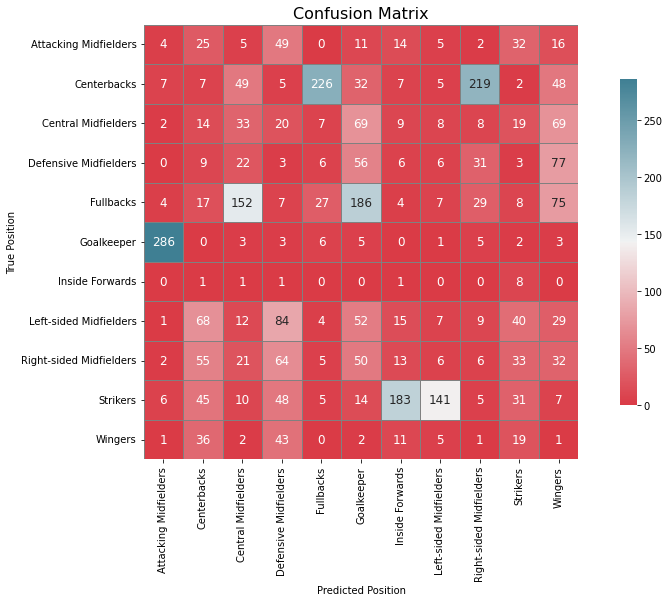

In [ ]:
cm = confusion_matrix(y_real, cluster_assignments)

# define color scheme
cmap = sns.diverging_palette(10, 220, as_cmap=True)
norm = plt.Normalize(cm.min(), cm.max())

fig,ax = plt.subplots()
fig.set_size_inches(15,8)
# create heatmap with custom color scheme
sns.heatmap(cm, cmap=cmap, annot=True, fmt='d', square=True,
            xticklabels=list(y_test.columns), yticklabels=list(y_test.columns),
            annot_kws={'fontsize':12}, cbar_kws={"shrink": .75},
            vmin=-1, vmax=1, center=0, norm=norm,
            linewidths=.5, linecolor='gray')
plt.xlabel('Predicted Position')
plt.ylabel('True Position')
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# Other Networks:

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa

from keras import regularizers
from keras.layers import Dropout, BatchNormalization

metric = tfa.metrics.F1Score(num_classes=y_train.shape[1])

# Define the model architecture with modifications
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='elu', input_shape=(40,), kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    tf.keras.layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    tf.keras.layers.Dense(256, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    tf.keras.layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    tf.keras.layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

# Compile the model with modifications
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy',metric])

# Train the model with modifications
history = model.fit(X_train, y_train, epochs=2500, batch_size=64, validation_data=(X_test, y_test))

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa

from keras import regularizers
from keras.layers import Dropout, BatchNormalization

metric = tfa.metrics.F1Score(num_classes=y_train.shape[1])

# Define the model architecture with modifications
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='elu', input_shape=(40,), kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),
    tf.keras.layers.Dense(256, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),
    tf.keras.layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),
    tf.keras.layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

# Compile the model with modifications
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy',metric])

# Train the model with modifications
history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test))

# Convolutional Neural Network:

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

# reshape X data for use in a CNN
X_train = np.array(X_train)
X_test = np.array(X_test)
X_train_cnn = X_train.reshape(X_train.shape[0], 5, 8, 1)
X_test_cnn = X_test.reshape(X_test.shape[0], 5, 8, 1)

# build CNN model
model_cnn = Sequential()
model_cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(5, 8, 1)))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(y_train.shape[1], activation='softmax'))

# compile model
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
model_cnn.fit(X_train_cnn, y_train, batch_size=32, epochs=10, validation_split=0.1)

# evaluate model
score_cnn = model_cnn.evaluate(X_test_cnn, y_test, verbose=0)
print('Test loss:', score_cnn[0])
print('Test accuracy:', score_cnn[1])



Epoch 1/10
166/166 [==============================] - 4s 8ms/step - loss: 5.9744 - accuracy: 0.0754 - val_loss: 3.1276 - val_accuracy: 0.0000e+00
Epoch 2/10
166/166 [==============================] - 1s 4ms/step - loss: 2.9164 - accuracy: 0.1134 - val_loss: 3.3633 - val_accuracy: 0.0000e+00
Epoch 3/10
166/166 [==============================] - 1s 4ms/step - loss: 2.7744 - accuracy: 0.1342 - val_loss: 3.7317 - val_accuracy: 0.0000e+00
Epoch 4/10
166/166 [==============================] - 1s 4ms/step - loss: 2.6505 - accuracy: 0.1589 - val_loss: 4.1027 - val_accuracy: 0.0000e+00
Epoch 5/10
166/166 [==============================] - 1s 6ms/step - loss: 2.5561 - accuracy: 0.1876 - val_loss: 3.8037 - val_accuracy: 0.0000e+00
Epoch 6/10
166/166 [==============================] - 1s 8ms/step - loss: 2.5240 - accuracy: 0.1956 - val_loss: 3.8119 - val_accuracy: 0.0000e+00
Epoch 7/10
166/166 [==============================] - 1s 7ms/step - loss: 2.4617 - accuracy: 0.2082 - val_loss: 3.6168 - val

21/21 [==============================] - 0s 3ms/step


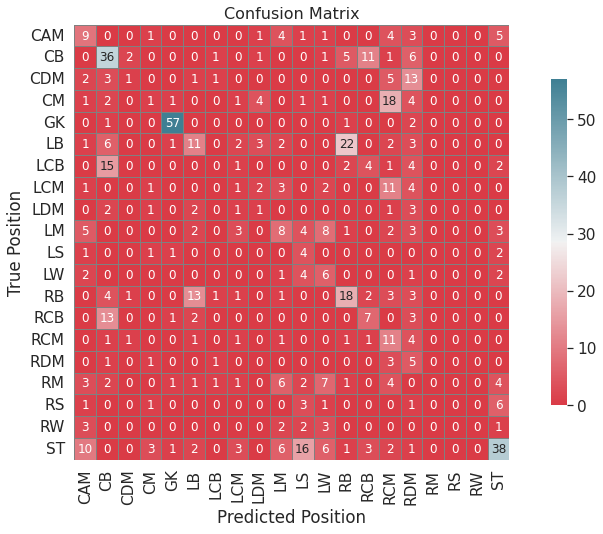

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred_onehot = model_cnn.predict(X_test_cnn)
y_pred_labels = np.argmax(y_pred_onehot, axis=1)

# Generate confusion matrix
cm = confusion_matrix(np.argmax(np.array(y_test), axis=1), y_pred_labels)

# define color scheme
cmap = sns.diverging_palette(10, 220, as_cmap=True)
norm = plt.Normalize(cm.min(), cm.max())

fig,ax = plt.subplots()
fig.set_size_inches(15,8)
# create heatmap with custom color scheme
sns.heatmap(cm, cmap=cmap, annot=True, fmt='d', square=True,
            xticklabels=list(y_test.columns), yticklabels=list(y_test.columns),
            annot_kws={'fontsize':12}, cbar_kws={"shrink": .75},
            vmin=-1, vmax=1, center=0, norm=norm,
            linewidths=.5, linecolor='gray')
plt.xlabel('Predicted Position')
plt.ylabel('True Position')
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test_tf, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.337305784225464
Test accuracy: 0.3031674325466156


In [ ]:
# Import necessary libraries
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_pos, test_size=0.2, random_state=42)

In [ ]:
# Oversample the data using SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

ValueError: ignored

In [ ]:
# Oversample the data using SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Define the neural network architecture
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Self-Organizing Maps

This code defines a SOM model with a single hidden layer of 100 units, a softmax output layer with a size equal to the number of units in the SOM grid, and a categorical cross-entropy loss function. The model is trained using a custom training loop that iteratively updates the weights based on the winner unit and the learning rate and decay function. The cluster labels are obtained by taking the argmax of the model's output for each player.

Note that this code assumes a rectangular SOM grid and a sigmoid activation function for the hidden layer. You may need to adjust the SOM hyperparameters, the number of units in the hidden layer, and the activation function to obtain the best results for your specific data and problem. You may also want to visualize the SOM to better understand the clusters and their relationships.

I have a dataframe X that contains statistics of players, what I want to achieve is to group them according to their characteristics by unsupervised learning. I want to make a basic Self Organized Maps with Keras and without using other libraries like MiniSom. Show me the code.

In [ ]:
y = df_resampled['Position']
X = df_resampled.drop('Position', axis=1)

scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [ ]:
def create_som(x_dim, y_dim, input_dim):
    model = Sequential()
    model.add(Dense(input_dim, input_shape=(input_dim,), activation='relu'))
    model.add(Dense(x_dim*y_dim, activation='relu'))
    model.add(Dense(input_dim, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
    return model


In [ ]:
x_dim = 10
y_dim = 10
input_dim = X.shape[1]

model = create_som(x_dim, y_dim, input_dim)
model.fit(X_minmax, X_minmax, epochs=100, verbose=1, batch_size=64)

Epoch 1/100
163/163 [==============================] - 1s 3ms/step - loss: 0.1068
Epoch 2/100
163/163 [==============================] - 0s 3ms/step - loss: 0.0488
Epoch 3/100
163/163 [==============================] - 0s 2ms/step - loss: 0.0380
Epoch 4/100
163/163 [==============================] - 0s 2ms/step - loss: 0.0371
Epoch 5/100
163/163 [==============================] - 0s 2ms/step - loss: 0.0367
Epoch 6/100
163/163 [==============================] - 0s 3ms/step - loss: 0.0364
Epoch 7/100
163/163 [==============================] - 0s 2ms/step - loss: 0.0362
Epoch 8/100
163/163 [==============================] - 0s 2ms/step - loss: 0.0360
Epoch 9/100
163/163 [==============================] - 0s 2ms/step - loss: 0.0359
Epoch 10/100
163/163 [==============================] - 1s 4ms/step - loss: 0.0358
Epoch 11/100
163/163 [==============================] - 1s 5ms/step - loss: 0.0357
Epoch 12/100
163/163 [==============================] - 1s 4ms/step - loss: 0.0356
Epoch 13/100


In [ ]:
predictions = model.predict(X_minmax)
cluster_labels = np.argmin(np.linalg.norm(predictions[:, np.newaxis] - model.get_weights()[0], axis=-1), axis=-1)

326/326 [==============================] - 1s 3ms/step


In [ ]:
df_labels = df_resampled.copy()
df_labels['cluster'] = cluster_labels

In [ ]:
y[0:50]

0      LB
1      LB
2     RCM
3      RM
4      LB
5     CAM
6     CDM
7      LB
8      ST
9      LM
10    CAM
11    LCB
12     CB
13    RWB
14     RM
15     ST
16    LDM
17     CB
18    CDM
19     ST
20     LB
21     LM
22    LDM
23     ST
24    LCM
25     CB
26     CB
27    RDM
28     GK
29     RS
30     RB
31     CM
32     CB
33     CM
34     LS
35    LCM
36     LB
37     LB
38     RB
39     LB
40     RW
41     LM
42     RB
43     ST
44     ST
45    LCB
46     RM
47    RCB
48    CAM
49     RW
Name: Position, dtype: object

In [ ]:
cluster_labels[0:50]

array([15,  5, 13, 15, 15, 15, 15,  4, 23, 13, 15,  4, 20, 15, 15, 15, 20,
       36, 15, 23,  4, 15, 15, 35, 23, 20, 20, 20, 36, 15,  5, 15, 15, 13,
       35, 13,  4,  4, 13, 15, 13, 35, 20,  5, 35, 20, 20, 20, 15, 13])

# Matches

In [ ]:
df_match = pd.read_sql_query("SELECT * FROM Match", conn)
df_match.head()

id  country_id  league_id     season  stage                 date  \
0   1           1          1  2008/2009      1  2008-08-17 00:00:00   
1   2           1          1  2008/2009      1  2008-08-16 00:00:00   
2   3           1          1  2008/2009      1  2008-08-16 00:00:00   
3   4           1          1  2008/2009      1  2008-08-17 00:00:00   
4   5           1          1  2008/2009      1  2008-08-16 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  ...  \
0        492473              9987              9993               1  ...   
1        492474             10000              9994               0  ...   
2        492475              9984              8635               0  ...   
3        492476              9991              9998               5  ...   
4        492477              7947              9985               1  ...   

    SJA   VCH   VCD   VCA   GBH   GBD   GBA   BSH   BSD   BSA  
0  4.00  1.65  3.40  4.50  1.78  3.25  4.00  1.73  3.40  4.20  
1  3.80  2.00  3.25  3.25  1.85  3.25  3.75  1.91  3.25  3.60  
2  2.50  2.35  3.25  2.65  2.50  3.20  2.50  2.30  3.20  2.75  
3  7.50  1.45  3.75  6.50  1.50  3.75  5.50  1.44  3.75  6.50  
4  1.73  4.50  3.40  1.65  4.50  3.50  1.65  4.75  3.30  1.67  

[5 rows x 115 columns]

In [ ]:
df_match.columns[0:100]

Index(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal', 'home_player_X1', 'home_player_X2',
       'home_player_X3', 'home_player_X4', 'home_player_X5', 'home_player_X6',
       'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10',
       'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3',
       'away_player_X4', 'away_player_X5', 'away_player_X6', 'away_player_X7',
       'away_player_X8', 'away_player_X9', 'away_player_X10',
       'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3',
       'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7',
       'home_player_Y8', 'home_player_Y9', 'home_player_Y10',
       'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 'away_player_Y3',
       'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7',
       'away_player_Y8', 'away_

# Team Attributes:

In [ ]:
df_team_att = pd.read_sql_query("SELECT * FROM Team_Attributes", conn)
df_team_att.head()

id  team_fifa_api_id  team_api_id                 date  buildUpPlaySpeed  \
0   1               434         9930  2010-02-22 00:00:00                60   
1   2               434         9930  2014-09-19 00:00:00                52   
2   3               434         9930  2015-09-10 00:00:00                47   
3   4                77         8485  2010-02-22 00:00:00                70   
4   5                77         8485  2011-02-22 00:00:00                47   

  buildUpPlaySpeedClass  buildUpPlayDribbling buildUpPlayDribblingClass  \
0              Balanced                   NaN                    Little   
1              Balanced                  48.0                    Normal   
2              Balanced                  41.0                    Normal   
3                  Fast                   NaN                    Little   
4              Balanced                   NaN                    Little   

   buildUpPlayPassing buildUpPlayPassingClass  ... chanceCreationShooting  \
0                  50                   Mixed  ...                     55   
1                  56                   Mixed  ...                     64   
2                  54                   Mixed  ...                     64   
3                  70                    Long  ...                     70   
4                  52                   Mixed  ...                     52   

   chanceCreationShootingClass chanceCreationPositioningClass  \
0                       Normal                      Organised   
1                       Normal                      Organised   
2                       Normal                      Organised   
3                         Lots                      Organised   
4                       Normal                      Organised   

   defencePressure defencePressureClass  defenceAggression  \
0               50               Medium                 55   
1               47               Medium                 44   
2               47               Medium                 44   
3               60               Medium                 70   
4               47               Medium                 47   

  defenceAggressionClass defenceTeamWidth  defenceTeamWidthClass  \
0                  Press               45                 Normal   
1                  Press               54                 Normal   
2                  Press               54                 Normal   
3                 Double               70                   Wide   
4                  Press               52                 Normal   

  defenceDefenderLineClass  
0                    Cover  
1                    Cover  
2                    Cover  
3                    Cover  
4                    Cover  

[5 rows x 25 columns]